# <span id="top">Notebook for universal text representation</span>
## Summary
<ol>
    <li><a href="#library_download_and_import">Installation and import of needed library</a></li>
    <li><a href="#translation_class">Definition of translation class</a></li>
    <li><a href="#configuration_class">Configuration class</a></li>
    <li><a href="#prepocessing_class">Prepocessing class</a></li>
    <li><a href="#autoencoder_generator">Auto encoder generator</a></li>
    <li><a href="#general_encoder_generator">General genererator encoder</a></li>
    <li><a href="#english_encoder">Construction english auto encoder</a>
        <ol>
            <li><a href="#">Loading data of english encoder</a></li>
            <li><a href="#">English model encoder</a></li>
            <li><a href="#">get english weigth</a></li>
            <li><a href="#english_supervised_decoder">English supervised decoder</a></li>
        </ol>
     </li>
    <li><a href="#">French management</a>
        <ol>
            <li><a href="#french_supervised_encoder">French supervised encoder</a></li>
            <li><a href="#french_supervised_decoder">French supervised decoder</a></li>
        </ol>
    </li>
    
</ol>


Tous les encodeurs doivent avoir la meme taille de sortie.<br />
La taille de sortie d'un encodeur doit etre la taille d'entree des des decodeurs.<br>

<b>DECODER_INPUT_SIZE=200<br>
encoder_output_length=200<br>
encoder_input=Phrase la plus longue de du langage donc on construit la longueur.<br></b>
Une astuce pour avoir la taille du vecteur de sortie ou d'entree des decodeurs ou encodeurs est de recuperer la plus grande phrase en terme de longeur de tous notre jeu de donnees.


## <span id="library_download_and_import">Installation and importation of needed library</span>

<a href="#top">Back to summary</a>

In [375]:
!pip install keras==2.4.3

In [376]:
#!pip install gdown
#!pip install emoji
#!pip install fasttext
#!pip install unidecode
#!pip install gensim==3.8.3
import tensorflow as tf
import logging,os 
tf.get_logger().setLevel(logging.ERROR)

logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#tf.logging.set_verbosity(tf.logging.ERROR)


import keras

#import gdown
import json
import numpy as np
#import emoji
import re
import string
import fasttext
import fasttext.util
#from gensim.models.wrappers import FastText
from gensim.models import KeyedVectors
#from gensim.models.wrappers import FastText

import pandas as pd

#Translation model

from keras.models import Sequential,Model
from keras.layers import Dense,Embedding, GRU, TimeDistributed, RepeatVector, LSTM,Attention, Bidirectional,AdditiveAttention, Concatenate,Lambda,Layer,Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

#translation class needed
from gensim.models import Word2Vec

import numpy as np
#from nltk.corpus import stopwords
import time
import pickle
import nltk
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from string import punctuation
import pandas as pd
import random, json, string

from keras.callbacks import ModelCheckpoint
#Translation model

from keras.models import Sequential
from keras.layers import Dense,Embedding, GRU, TimeDistributed, RepeatVector, LSTM, Bidirectional,Input,Concatenate,concatenate
from keras.preprocessing.text import Tokenizer

from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
import nltk
import string
import pandas as pd
import re
import tensorflow.keras.backend as K

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Embedding, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers



from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine

## <span id="translation_class">Definition of translation class</span>
This class have the function wihc init the architecture of an encoder and ethe arichitecture of decoder. It also have the function to init the surpervised encoder for english language<br>

<a href="#top">Back to summary</a>

In [377]:
np.random.seed(42)

tf.random.set_seed(42)

ACTION={}
ACTION["USE_SENTENCES"]= True #si ceci est a false, le decodeur sera entraine en utilisant les predictions fournies par l'encodeur et non ceux preenregistre
ACTION["INTERNAL_REPRESENTATION"]= True #cette configuration permet de savoir si nous allons travailler avec les representations interne ou bien les embediings.
ACTION["TRAIN_EN_AUTO_ENCODER"]= !True

ACTION["PREDICT_EN_AUTO_ENCODER"]= True
ACTION["TRAIN_EN_DECODER"]= True
ACTION["CREATE_EN_EMBEDDING"]= True
ACTION["CREATE_EN_ENCODING"]=  True
ACTION["EVALUATE_EN_DECODER"]= True

ACTION["TRAIN_FR_AUTO_ENCODER"]= !True
ACTION["TRAIN_FR_ENCODER"]= True
ACTION["PREDICT_FR_ENCODER"]= True
ACTION["TRAIN_FR_DECODER"]= !True
ACTION["CREATE_FR_ENCODING"]= !True
ACTION["CREATE_FR_EMBEDDING"]= !True
ACTION["EVALUATE_FR_DECODER"]= True


ACTION["EVALUATE_EN_FR"]= True
ACTION["EVALUATE_FR_EN"]= True

ACTION["TRAIN_SPANISH_ENCODER"]= True
ACTION["TRAIN_SPANISH_DECODER"]= True
ACTION["CREATE_SPANISH_ENCODING"]= True
ACTION["EVALUATE_SPANISH_DECODER"]= True

ACTION["EVALUATE_FR_SPANISH"]= True
ACTION["EVALUATE_EN_SPANISH"]= True

ACTION["EVALUATE_SPANISH_EN"]= True
ACTION["EVALUATE_SPANISH_FR"]= True

#yemba

ACTION["CREATE_YEMBA_ENCODING"]= True
ACTION["TRAIN_YEMBA_ENCODER"]= True
ACTION["TRAIN_YEMBA_DECODER"]= True
ACTION["EVALUATE_YEMBA_EN"]= True
ACTION["EVALUATE_YEMBA_SPANISH"]= True
ACTION["EVALUATE_YEMBA_FR"]= True
ACTION["EVALUATE_FR_YEMBA"]= True
ACTION["EVALUATE_SPANISH_YEMBA"]= True
ACTION["EVALUATE_EN_YEMBA"]= True

ACTION["EVALUATE_YEMBA_DECODER"]= True
#Ewondo

ACTION["TRAIN_EWONDO_ENCODER"]= !True
ACTION["TRAIN_EWONDO_DECODER"]= !True
ACTION["CREATE_EWONDO_ENCODING"]= True
ACTION["EVALUATE_EWONDO_FR"]= !True
ACTION["EVALUATE_EWONDO_EN"]= True
ACTION["EVALUATE_EWONDO_SPANISH"]= True
ACTION["EVALUATE_SPANISH_EWONDO"]= True
ACTION["EVALUATE_EN_EWONDO"]= True
ACTION["EVALUATE_FR_EWONDO"]= !True

ACTION["EVALUATE_EWONDO_DECODER"]= True


ACTION["TPU"]=False
ACTION["GPU"]=True
ACTION["DECODER_REGRESSION"]=True
ACTION["SEQ2SEQ"]=True

In [378]:
ENCODER_OUTPUT_SIZE=50 #pre_en_en.max_length_source
DECODER_INPUT_SIZE=50 #pre_en_en.max_length_source
MAX_LENGTH_SENTENCE=50
MAX_LENGTH_SOURCE=50
MAX_LENGTH_TARGET=50
VERBOSE=2
NROWS=160000
NB_EPOCHS=35
NB_ENCODER_EPOCHS=35
NB_DECODER_EPOCHS=35
EMBEDDING_SIZE=100

In [379]:
import os
def init_all_txt_files():
    pass
    

In [380]:
if ACTION["TPU"]==True:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

    print("REPLICAS: ", strategy.num_replicas_in_sync)

In [381]:
if ACTION["TPU"]==True:
    MIXED_PRECISION = False
    XLA_ACCELERATE = True

    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        if tpu: 
            policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
        else: 
            policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')

    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

In [382]:
class TranslateModel:
    def __init__(self):
        self.tokenizer_source=Tokenizer()
        self.tokenizer_target=Tokenizer()
        self.vocab_size_source=0
        self.vocab_size_target=0
        self.max_length_source=0
        self.max_length_target=0
        self.encoder=[]
        self.decoder=[]
        self.model=Sequential()
    
    def init_autoencoder_seq2seq(self,conf):
        self.encoder_inputs = Input(shape=(None,),name="encoder_input")
        self.enc_emb =  Embedding(conf.vocab_size_source, conf.embedding_dim, mask_zero = True,name="encoder_embedding")(self.encoder_inputs)
        self.encoder_lstm = LSTM(conf.embedding_dim*2, return_state=True,name="encoder_lstm")
        self.encoder_outputs, self.state_h, self.state_c = self.encoder_lstm(self.enc_emb)
        # We discard `encoder_outputs` and only keep the states.
        self.encoder_states = [self.state_h, self.state_c]
        
        # Set up the decoder, using `encoder_states` as initial state.
        self.decoder_inputs = Input(shape=(None,),name="decoder_input")
        self.dec_emb_layer = Embedding(conf.vocab_size_target, conf.embedding_dim, mask_zero = True,name="decoder_embedding")
        self.dec_emb = self.dec_emb_layer(self.decoder_inputs)

        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the
        # return states in the training model, but we will use them in inference.
        self.decoder_lstm = LSTM(conf.embedding_dim*2, return_sequences=True, return_state=True,name="decoder_lstm")
        self.decoder_outputs, _, _ = self.decoder_lstm(self.dec_emb, initial_state=self.encoder_states)

        # Use a softmax to generate a probability distribution over the target vocabulary for each time step
        self.decoder_dense = Dense(conf.vocab_size_target, activation='softmax',name="decoder_dense")
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

        # Compile the model
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])
        self.model.summary()
    def cut_model_encoder_decoder(self):
        """Cette fonction va permettre de recouper un modele seq2seq en encodeur decodeur"""
        self.encoder=Model(self.encoder_inputs,self.encoder_states)
        #Construction of encoder who gave hidden state
        self.encoder_hidden=Model(self.encoder_inputs,self.state_h)
        #decoder setup
        # Decoder setup
        # Below tensors will hold the states of the previous time step
        decoder_state_input_h = Input(shape=(self.conf.embedding_dim*2,))
        decoder_state_input_c = Input(shape=(self.conf.embedding_dim*2,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        # Get the embeddings of the decoder sequence
        dec_emb2= self.dec_emb_layer(self.decoder_inputs)

        # To predict the next word in the sequence, set the initial states to the states from the previous time step
        decoder_outputs2, state_h2, state_c2 = self.decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
        decoder_states2 = [state_h2, state_c2]
        decoder_outputs2 = self.decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary
        

        # Final decoder model
        self.decoder= Model(
            [self.decoder_inputs] + decoder_states_inputs,
            [decoder_outputs2] + decoder_states2)
    
    def infer_seq2seq2(self,input_seqs,tokenizer_target,start_token="<starttoken>"):
        """Fonction permettant d'inferer sur plusieurs seqs a la fois"""
        states_values=self.encoder.predict(input_seqs)
        all_sentences_decoded=[]
        for kl in range(len(states_values[0])):
            target_seq=np.zeros((1,1))
            #print(target_seq.shape)
            target_seq[0,0]=tokenizer_target.word_index[start_token.lower()]
            stop_condition=False
            decoded_sentence=''
            i=0
            n_state_value=[np.array([states_values[0][kl]]),np.array([states_values[1][kl]])]
            while not stop_condition:
                output_tokens,h,c=self.decoder.predict([target_seq]+n_state_value)
                
                seqs=[np.argmax(elt) for elt in (vect for vect  in output_tokens)]
                sampled_token_index=np.argmax(output_tokens[0,-1,:])
                
                sampled_char=""
                if sampled_token_index!=0:
                    sampled_char=tokenizer_target.index_word[sampled_token_index]
                    
                    decoded_sentence+=" "+sampled_char
                if sampled_char=="<endtoken>" or  i==self.max_length_target+1:
                    stop_condition=True

                target_seq = np.zeros((1, 1))
                target_seq[0, 0] = sampled_token_index
                #print(target_seq)
                i+=1
                # Update states
                n_state_value = [h, c]
            all_sentences_decoded.append(decoded_sentence)
        return all_sentences_decoded
            
    def infer_seq2seq(self,input_seq,tokenizer_target,start_token="<starttoken>"):
        new_input=np.reshape(input_seq,(1,input_seq.shape[0]))
        states_value=self.encoder.predict(new_input)
        target_seq=np.zeros((1,1))
        #print(target_seq.shape)
        target_seq[0,0]=tokenizer_target.word_index[start_token.lower()]
        stop_condition=False
        decoded_sentence=''
        i=0
        while not stop_condition:
            output_tokens,h,c=self.decoder.predict([target_seq]+states_value)
            #print(output_tokens.shape)
            seqs=[np.argmax(elt) for elt in (vect for vect  in output_tokens)]
            #print(seqs)
            #print(pre_en_en.tokenizer_source.sequences_to_texts([seqs]))

            sampled_token_index=np.argmax(output_tokens[0,-1,:])
            #print("Hello ->",sampled_token_index)
            sampled_char=""
            if sampled_token_index!=0:
                sampled_char=tokenizer_target.index_word[sampled_token_index]
                #print(sampled_char)
                #print("Yes->",sampled_char)
                decoded_sentence+=" "+sampled_char
            if sampled_char=="<endtoken>" or  i==8:
                stop_condition=True

            # Update the target sequence (of length 1).
            #target_seq = np.zeros((5,5))
            #target_seq[i, i] = sampled_token_index
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            #print(target_seq)
            i+=1
            # Update states
            states_value = [h, c]
        return decoded_sentence
    
    def infer_many(self,inputs,tokenizer):
        predicted_texts=[]
        for elt in inputs:
            predicted_texts.append(self.infer_seq2seq(elt,tokenizer))
        return predicted_texts
    
    def init_decoder_seq2seq(self,conf):
        """
        L'encodeur prendra en entre la sortie de l'encodeur supervise, le decodeur prendra en entre
        la phrase X  cache a predire
        """
        self.encoder_inputs = Input(shape=(None,conf.embedding_dim*2),name="encoder_input")
        #self.enc_emb =  Embedding(conf.vocab_size_source, conf.embedding_dim, mask_zero = True,name="encoder_embedding")
        #self.encoder_lstm = LSTM(conf.embedding_dim*2, return_state=True,name="encoder_lstm")(self.encoder_inputs)
        #self.encoder_outputs, self.state_h, self.state_c = self.encoder_lstm(self.enc_emb)
        self.encoder_outputs, self.state_h, self.state_c = LSTM(conf.embedding_dim*2, return_state=True,name="encoder_lstm")(self.encoder_inputs)
        # We discard `encoder_outputs` and only keep the states.
        self.encoder_states = [self.state_h, self.state_c]
        
        # Set up the decoder, using `encoder_states` as initial state.
        self.decoder_inputs = Input(shape=(None,),name="decoder_input")
        self.dec_emb_layer = Embedding(conf.vocab_size_target, conf.embedding_dim, mask_zero = True,name="decoder_embedding")
        self.dec_emb = self.dec_emb_layer(self.decoder_inputs)

        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the
        # return states in the training model, but we will use them in inference.
        self.decoder_lstm = LSTM(conf.embedding_dim*2, return_sequences=True, return_state=True,name="decoder_lstm")
        self.decoder_outputs, _, _ = self.decoder_lstm(self.dec_emb, initial_state=self.encoder_states)

        # Use a softmax to generate a probability distribution over the target vocabulary for each time step
        self.decoder_dense = Dense(conf.vocab_size_target, activation='softmax',name="decoder_dense")
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

        # Compile the model
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])
        self.model.summary()
    
    def init_auto_encoder_model(self,conf):
        #print(config)
        self.model=Sequential()
        self.model.add(Embedding(conf.vocab_size_source,conf.embedding_dim,input_length=conf.max_length_source,mask_zero=True))
        self.model.add(LSTM(conf.max_length_target))
        self.model.add(RepeatVector(conf.max_length_target))
            
        #decoder
        self.model.add(LSTM(conf.max_length_target,return_sequences=True))
        self.model.add(TimeDistributed(Dense(conf.vocab_size_target,activation="softmax")))
        self.model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
        self.model.summary()
    
    def init_auto_encoder_maner2(self,conf):
        
        inp0=Input(shape=(conf.max_length_source,))
        encod=Embedding(conf.vocab_size_source,conf.embedding_dim)(inp0)
        lstm_layer,hidden_state,cell_state=LSTM(ENCODER_OUTPUT_SIZE,return_sequences=True,return_state=True)(encod)
        
        decoder=RepeatVector(conf.max_length_target)(hidden_state)
        decoder=LSTM(ENCODER_OUTPUT_SIZE,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        
        context=AdditiveAttention(dropout=0.3)([decoder,lstm_layer])
        decoder=concatenate([context,decoder])
        out=TimeDistributed(Dense(conf.vocab_size_target,activation="softmax"))(decoder)
        
        self.model=Model(inputs=inp0,outputs=out)
        optimizer=conf.optimizer
        self.model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
        
    def init_auto_encoder_maner3(self,conf):
        inp0=Input(shape=(conf.max_length_source,))
        encod=Embedding(conf.vocab_size_source,conf.embedding_dim)(inp0)
        lstm_layer,hidden_state,cell_state=LSTM(ENCODER_OUTPUT_SIZE,return_sequences=True,return_state=True)(encod)
        decoder=RepeatVector(ENCODER_OUTPUT_SIZE)(hidden_state)
        decoder=LSTM(conf.max_length_target,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        context=AdditiveAttention()([decoder,lstm_layer])
        decoder=concatenate([context,decoder])
        out=TimeDistributed(Dense(conf.vocab_size_target,activation="softmax"))(decoder)
        optimizer=conf.optimizer
        self.model=Model(inputs=inp0,outputs=[out])
        self.model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
    
    def init_hidden_state_model(self,conf,model):
        """Ce modele permettra de faire la prediction des hidden state
            et autre
        """
        inp0=Input(shape=(conf.max_length_source,))
        embedding=Embedding(conf.vocab_size_source,embedding_size,weights=model.layers[1].get_weights(),trainable=False)(inp0)
        #lstm=LSTM(conf.max_length_target)(embedding)
        lstm,hidden,cell=model.layers[2](embedding)
        model=Model(inputs=inp0,outputs=hidden)
        #model.layers[2].set_weights(model.layers[2].get_weights())
        self.model=model
    
    def init_hidden_state_model2(self,conf,model):
        """Ce modele permettra de faire la prediction des hidden state
            et autre
        """
        inp0=Input(shape=(conf.max_length_source,))
        embedding=Embedding(conf.vocab_size_source,embedding_size,weights=model.layers[1].get_weights(),trainable=False)(inp0)
        #lstm=LSTM(conf.max_length_target)(embedding)
        lstm,hidden,cell=model.layers[2](embedding)
        
        decoder=model.layers[3](hidden)
        decoder=model.layers[4](decoder,initial_state=[hidden,cell])
        context=model.layers[5]([decoder,lstm])
        decoder=concatenate([context,decoder])
        out=TimeDistributed(Dense(conf.vocab_size_target,activation="softmax"))(decoder)
        model=Model(inputs=inp0,outputs=[hidden,context])
        self.model=model
    
    def init_supervised_encoder(self,config):
        """
            Cette architecture servira d'architecture de base
            a tous les modeles encoder supervise
            des differentes langue
        """
        #print(config)
        self.model=Sequential()
        self.model.add(Embedding(config.vocab_size_source,config.embedding_dim,input_length=config.max_length_source,mask_zero=True,trainable=False))
        self.model.add(Bidirectional(LSTM(config.max_length_target),input_shape=(config.max_length_source,1)))
        self.model.add(RepeatVector(config.max_length_target))
        self.model.add(LSTM(config.embedding_dim*2))
        self.model.add(Flatten())
        self.model.add(Dense(config.embedding_dim*2))
        self.model.compile(loss="mse",optimizer="adam",metrics=["mse","cosine_similarity","mae"])
    
    def init_supervised_encoder_embedding(self,config):
        """
            Cette architecture servira d'architecture de base
            a tous les modeles encoder supervise
            des differentes langue
        """
        print(config)
        self.model=Sequential()
        self.model.add(Embedding(config.vocab_size_source,config.embedding_dim,input_length=config.max_length_source,mask_zero=True,trainable=False))
        self.model.add(Bidirectional(LSTM(config.max_length_target)))
        self.model.add(RepeatVector(config.max_length_target))
        self.model.add(LSTM(config.embedding_dim*2))
        self.model.add(Flatten())
        self.model.add(Dense(config.embedding_dim*2))
        self.model.compile(loss="mse",optimizer="adam",metrics=["mse","cosine_similarity","mae"])
    
    def init_supervised_encoder2(self,config):
        self.model=Sequential()
        #self.model.add(Embedding(config.vocab_size_source,config.embedding_dim,input_length=config.max_length_source,mask_zero=True,trainable=False))
        self.model.add(Bidirectional(LSTM(config.max_length_target),input_shape=(config.max_length_source,1)))
        self.model.add(RepeatVector(config.max_length_target))
        self.model.add(LSTM(config.max_length_target,return_sequences=True))
        self.model.add(Dense(config.embedding_dim,activation="sigmoid"))
        self.model.compile(loss="mse",optimizer="adam",metrics=[tf.keras.metrics.AUC()])
    
    def init_supervised_encoder_with_dense(self,config):
        self.model=Sequential()
        self.model.add(Input(shape=(config.max_length_source,)))
        self.model.add(Dense(config.max_length_source,activation="relu"))
        self.model.add(Dense(config.max_length_target,activation="relu"))
        #self.model.compile(loss="mae",optimizer="adam",metrics=["mse"])
        self.model.compile(loss="cosine_similarity",optimizer="adam",metrics=["mse","mae"])
    
    
    def init_supervised_encoder_with_attention(self,config):
        inp0=Input(shape=(config.max_length_source,))
        
        #gru,hidden_state,cell_state=LSTM(config.max_length_target,return_sequences=True,return_state=True,dropout=0.4)(inp0)
        #begin to construct decoder
        #decoder=RepeatVector(config.max_length_target)(hidden_state)
        decoder=RepeatVector(config.max_length_target)(inp0)
        
        #decoder=LSTM(config.max_length_target,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        decoder=LSTM(1,return_sequences=True)(decoder)
        #add attention
        attention=AdditiveAttention(dropout=0.3)([decoder,inp0])
        context=concatenate([attention,decoder])
        #flatten=Flatten()(context)
        flatten=Flatten()(decoder)
        output=Dense(config.max_length_target,activation="sigmoid")(flatten)
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="mse",optimizer="adam",metrics=["mse","mae"])
        
        
    
    def init_supervised_decoder(self,config):
        #print(config)
        """
            Cette architecture servira de modele de base au decodeur supervise
            de chaque
            Langue
        """
        self.model=Sequential()
        self.model.add(LSTM(config.max_length_target,input_shape=(config.max_length_source,1),return_sequences=True))
        #self.model.add(RepeatVector(config.max_length_target))
        #self.model.add(LSTM(1,return_sequences=True))
        self.model.add(TimeDistributed(Dense(config.vocab_size_target,activation="softmax")))
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def init_supervised_decoder_with_regression(self,config):
        #Cette fonction nous allons essayer de construit un modele,
        #basse sur la regression
        self.model=Sequential()
        self.model.add(LSTM(config.max_length_target,input_shape=(config.max_length_source,1),return_sequences=True))
        self.model.add(TimeDistributed(Dense(config.max_length_source)))
        self.model.compile(loss="mse",optimizer="adam",metrics=["mae"])
    
    def init_supervised_decoder_with_attention(self,config):
        inp0=Input(shape=(config.max_length_source,config.embedding_dim))
        gru,hidden_state,cell_state=LSTM(config.max_length_target,return_sequences=True,return_state=True)(inp0)
        #decodercer begin
        decoder=RepeatVector(config.max_length_target)(hidden_state)
        
        decoder=LSTM(config.max_length_target,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        context=AdditiveAttention()([decoder,gru])
        decoder=concatenate([context,decoder])
        output=TimeDistributed(Dense(config.vocab_size_target,activation="softmax"))(decoder)
        
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def init_supervised_decoder_with_attention2(self,config):
        inp0=Input(shape=(config.max_length_source,1))
        gru,hidden_state,cell_state=LSTM(config.max_length_target,return_sequences=True,return_state=True)(inp0)
        #decodercer begin
        decoder=RepeatVector(config.max_length_target)(hidden_state)
        print("Max inside model ",config.max_length_target)
        decoder=LSTM(config.max_length_target,return_sequences=True)(decoder) #initial_state=[inp0,inp0]
        context=AdditiveAttention(dropout=0.3)([decoder,inp0])
        decoder=concatenate([context,decoder])
        output=TimeDistributed(Dense(config.vocab_size_target,activation="softmax"))(decoder)
        
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def init_supervised_decoder_with_auto_en(self,config,model):
        inp0=Input(shape=(config.max_length_source,))
        decoder=RepeatVector(config.max_length_target)(inp0)
        decoder=model.layers[4](decoder)
        attention=model.layers[5]([decoder,inp0])
        decoder=concatenate([attention,decoder])
        output=model.layers[7](decoder)
        
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
        
    def init_supervised_decoder_with_dense(self,config):
        self.model=Sequential()
        self.model.add(Input(shape=(config.max_length_source,1)))
        self.model.add(TimeDistributed(Dense(config.vocab_size_target,activation="softmax")))
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def train_model(self,x,y,epoch=30,begin=0):
        #modelcheckpoint=ModelCheckpoint("auto_save",save_best_only=True,verbose=1)
        new_model=self.model.fit(x,y,use_multiprocessing=True,epochs=epoch,batch_size=32,initial_epoch=begin)
        return new_model
    
    def save_embedding_layers(self):
        #embeddings=self.encoder.layers[1].get_weights()[0]
        word_embeddings={}
        #word_embeddings={word:embeddings[idx] for word,idx in self.tokenizer_source.word_index.items()}
        return word_embeddings
    
    def save_model(self,path):
        self.model.save(path)
    
    def predict_sequence(self,sequences,tokenizer,true_sequence=True,generator=False):
        """cette fonction permet de predire des sequences
            et si true_sequence est a true alors seule les elements a taille
            positive seront renvoyer
            @sequences doit etres soit un sequence
            @soit un un generateur et dans ce cas @genetrator doit etre a True
        """
        p_sequences=self.model.predict(sequences)
        seq_predicteds=[]
        for sequence in p_sequences:
            seq_predicteds.append([argmax(vector) for vector in sequence])
        texts=tokenizer.sequences_to_texts(seq_predicteds)
        return {"seqs":seq_predicteds,"texts":texts}
    
    def sequence_to_text(self,sequence,tokenizer):
        return tokenizer.sequence_to_text(sequence)
    
    def load_model(self,path):
        self.model=keras.models.load_model(path)
    
    def evaluate_model(self,sources_texts,predicted_texts):
        actual, predicted = list(), list()
        for i,text in enumerate(sources_texts):
            actual.append([text.split()])
            predicted.append(predicted_texts[i].split())
        # calculate BLEU score
        print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
        print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
        print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
        print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
        #print("BLEU-5: %f"%corpus_bleu(actual, predicted))

# <span id="">Classe de traduction propre a notre architecture</span>
Cette classe est creer ici car la traduction ne fait pas comme a l'accoutume. Ici il faut un encodeur et un decodeur
sauf pour l'anglais qui est la langue source.

<a href="#top">Back to summary</a>


In [383]:
class UniversalTranslator(TranslateModel):
    
    def make_translation(self,texts,encoder,decoder,pre=None):
        data_encoded=pre.encode_text_with_model(texts,encoder)
        predictions=decoder.predict(data_encoded)
        pred_real=[[argmax(v) for v in vector ] for vector in predictions]
        return pred_real
    

# <span id="configuration_class">Configuration class</span>
That class is used to store the model configuration

<br>
<a href="#top">Back to summary</a>

In [384]:
#configuration classe

class Config:
    def __init__(self,vocab_size=0,max_length=0,vocab_size_target=0,
                 max_length_target=0,embedding_dim=0,nb_classe=3,internal_size=None):
        """
            le vocab size sera le premier parametre de notre premiere
            couche Embedding dans keras
        """
        self.vocab_size_source=vocab_size
        self.max_length_source=max_length
        self.vocab_size_target=vocab_size_target
        self.max_length_target=max_length_target
        self.embedding_dim=embedding_dim
        self.nb_classe=nb_classe
        self.optimizer="adam"
        if internal_size==None:
            self.internal_size=self.max_length_source
        else:
            self.internal_size=internal_size
    
    def __str__(self):
        gth="Configuration is :\n"
        gth+="\n Vocab size source ="+str(self.vocab_size_source)
        gth+="\n Max length source ="+str(self.max_length_source)
        gth+="\n Vocab size target ="+str(self.vocab_size_target)
        gth+="\n Max length target= "+str(self.max_length_target) 
        gth+="\n embedding dim ="+str(self.embedding_dim)
        gth+="\n Nb classe= "+str(self.nb_classe)
        return gth

# <span id="prepocessing_class">Prepocessing class</span>
This classs have the different prepocessing class
<br>
<a href="#top">Back to summary</a>

In [385]:
class PrepoTranslation:
    def __init__(self):
        self.punctuation=string.punctuation+"»«'´’…‘”“,.?’'"
        self.tokenizer_source=[]
        self.tokenizer_target=[]
        self.sentences_source=[]
        self.sentences_target=[]
        self.embedding={}
        self.model_source=None
        self.model_target=None
        self.embedding_target={}
        self.sentences_embedding_source={}
        self.sentences_embedding_target={}
        self.max_length_source=0
        self.max_length_target=0
        self.vocab_size_source=0
        self.vocab_size_target=0
        self.test_id=[]
        self.sentences_test=[]
        self.sentences_test_target=[]
        self.all_sentences_source=[]
        self.all_sentences_target=[]
        self.start_token="<starttoken>"
        self.end_token="<endtoken>"
        self.unk_token="<UNKTOKEN>"
    
    def load_data(self):
        pass
    
    def get_sentences_representation(self,sentences,source=True):
        """Retourne la representation en phrase embedding des phrases passes en entre"""
        representations=[]
        if source==True:
            for elt in sentences:
                representations.append(self.sentences_embedding_source[elt])
        else:
            for elt in sentences:
                representations.append(self.sentences_embedding_target[elt])
        return np.array(representations)
    
    def texts_to_embedding(self,texts,source=True,embedding_size=50):
        sequences=[]
        sequence_to_padd=np.zeros(embedding_size)
        for text in texts:
            text_s=text.split()
            sequence=[]
            for elt in text_s:
                sequence.append(self.get_word_representation(elt,source))
                #print(len(self.get_word_representation(elt)))
            sequences.append(list(sequence))
            #print(text)
        #print(len(sequences))
        #print(len(texts))
        if source==True:
            sequences=self.pad_sequences_perso(sequences,self.max_length_source,value=sequence_to_padd)
        else:
            sequences=self.pad_sequences_perso(sequences,self.max_length_target,value=sequence_to_padd)
        for i,elt in enumerate(sequences):
            for j,elt2 in enumerate(elt):
                elt[j]=np.array(elt2)
            sequences[i]=np.array(elt)
        return np.array(sequences)
    
    
    def get_word_representation(self,word,size=50,source=True):
        #np.random.seed(42)
        #unk_token=np.random.uniform(-0.25, 0.25,size)
        try:
            #print("Word ",word, "have length ",len(self.embedding[word]))
            if source==True:
                return self.embedding[word]
            else:
                return self.embedding_target[word]
        except:
            #print("Word random ",word, "have length ",len(self.embedding[word]))
            return UNK_TOKEN
    
    def encode_text_for_model(self,texts,with_vect=True,source=True):
        """Permet de mettre le texte sous une forme que le model 
            pourra predire"""
        i=0
        for elt in texts:
            #elt=self.replace_punctuation(elt,self.punctuation)
            elt=" ".join(elt.split())
            texts[i]=elt
            i=i+1
        
        if(with_vect==False):
            if source==True:
                sequences=self.tokenizer_source.texts_to_sequences(texts)
                sequences=pad_sequences(sequences,self.max_length_source,padding="post",truncating="post")
            else:
                sequences=self.tokenizer_target.texts_to_sequences(texts)
                sequences=pad_sequences(sequences,self.max_length_target,padding="post",truncating="post")
        else:
            sequences=self.texts_to_embedding(texts,source)
                                
        i=0
        for seq in sequences:
            sequences[i]=np.array(seq)
            i=i+1
        return np.array(sequences)
    
    def encode_text_for_supervised_encoder(self,texts):
        """
        Cette fonction va faire un encodage du texte de telle sorte qu'il puisse etre consomme par un encodeur supervise
        ceci en tranformation chaque entier en un tableau numpy de taille un. Etant donne l'abasence de la couche embedding dans 
        l'architecture du modele
        """
        data=self.encode_text_for_model(texts,False)
        data_2=[]
        for vect in data:
            new_elt=[]
            for x in vect:
                new_elt.append(np.array([float(x)]))
            data_2.append(np.array(new_elt))
        return np.array(data_2)
    
    def encode_text_with_model(self,texts,model):
        """
        Cette fonction consiste a prendre un ensemble de textes le encodes et en fait une prediction
        et c'est cette prediction qui est renvoye au prochain model.
        """
        data=self.encode_text_for_supervised_encoder(texts)
        #print("Data shape is ",data.shape)
        predictions=model.predict(data)
        #print("Predictions inside have shape",predictions.shape)
        return predictions
    
    def encode_texts(self,texts_source,texts_target,with_vect=False,one_hot=False,embedding_size=50):
        i=0
        sources=[]
        targets=[]
        for i in range(len(texts_source)):
            text_source=texts_source[i]
            text_target=texts_target[i]
            #text_source=self.replace_punctuation(text_source,self.punctuation)
            #text_target=self.replace_punctuation(text_target,self.punctuation)
            s_split=text_source.split()
            text_target=" ".join(text_target.split())
            
            sources.append(" ".join(s_split))
            targets.append(text_target)
        #print(sources)
        #print(targets)
        if(with_vect==False):
            vector_source=self.tokenizer_source.texts_to_sequences(sources)
            vector_source=pad_sequences(vector_source,self.max_length_source,padding="post",truncating="post")
        else:
            vector_source=self.texts_to_embedding(sources,embedding_size=embedding_size)
        vector_target=self.tokenizer_target.texts_to_sequences(targets)
        
        vector_target=pad_sequences(vector_target,self.max_length_target,padding="post",truncating="post")
        if one_hot==True:
            vector_target=to_categorical(vector_target,self.vocab_size_target)
        
        for i in range(len(texts_source)):
            vector_source[i]=np.array(vector_source[i])
            vector_target[i]=np.array(vector_target[i])
        vector_source=np.array(vector_source)
        vector_target=np.array(vector_target).astype("float32")
        
        return vector_source,vector_target
            
    def pad_sequences_perso(self,sequences,max_length,value=0.0):
        i=0
        for sequence in sequences:
            length=len(sequence)
            if (length<max_length):
                diff=max_length-length
                for j in range(diff):
                    sequence.append(value)
            elif (length>max_length):
                diff=length-max_length
                for j in range(diff):
                    sequence.pop()
            sequences[i]=sequence
            i=i+1
        return sequences
    
    def save_sentence_on_file(self,path_source,path_target):
        """Sauvergared les phrases dans des fichiers texts"""
        with open(path_source,"w") as f:
            for elt in self.sentences_source:
                f.write(elt+"\n")
        
        with open(path_target,"w") as f:
            for elt in self.sentences_target:
                f.write(elt)
    
    
    def pickle_data(self,path):
        """Save the data like a pickle object in a file"""
        
        dict_data={
                    "tokenizer_target":self.tokenizer_target,
                    "sentences_target":self.sentences_target,
                    "sentences_source":self.sentences_source,
                    "max_length_target":self.max_length_target,
                    "max_length_source":self.max_length_source,
                    "vocab_size_target":self.vocab_size_target,
                    "vocab_size_source":self.vocab_size_source,
                    "tokenizer_source":self.tokenizer_source
        }
        try:
            dict_data["test_id"]=self.test_id
            dict_data["sentences_test"]=self.sentences_test
        except:
            pass
        with open(path,"wb") as f:
            pickle.dump(dict_data,f)
    
    
    def save_tokenizer(self,path):
        """Sauvegarde les informations sur le tokenizer"""
        dict_data={
            "tokenizer_target":self.tokenizer_target,
                    "max_length_target":self.max_length_target,
                    "max_length_source":self.max_length_source,
                    "vocab_size_target":self.vocab_size_target,
                    "vocab_size_source":self.vocab_size_source,
                    "tokenizer_source":self.tokenizer_source
        }
        with open(path,"wb") as f:
            pickle.dump(dict_data,f)
    
    def load_tokenizer(self,path):
        with open(path,"rb") as f:
            dict_data=pickle.loads(f.read())
            self.tokenizer_target=dict_data["tokenizer_target"]
            self.tokenizer_source=dict_data["tokenizer_source"]
            self.max_length_source=dict_data["max_length_source"]
            self.max_length_target=dict_data["max_length_target"]
            self.vocab_size_target=dict_data["vocab_size_target"]
            self.vocab_size_source=dict_data["vocab_size_source"]
    
    
    def load_data_from_bin(self,path):
        """Load picke object data from file"""
        with open(path,"rb") as f:
            dict_data=pickle.loads(f.read())
            self.tokenizer_target=dict_data["tokenizer_target"]
            self.tokenizer_source=dict_data["tokenizer_source"]
            self.max_length_source=dict_data["max_length_source"]
            self.max_length_target=dict_data["max_length_target"]
            self.vocab_size_target=dict_data["vocab_size_target"]
            self.vocab_size_source=dict_data["vocab_size_source"]
            self.sentences_source=dict_data["sentences_source"]
            self.sentences_target=dict_data["sentences_target"]
            try:
                self.test_id=dict_data["test_id"]
                self.sentences_test=dict_data["sentences_test"]
            except :
                pass
    
    def replace_punctuation(self,text,ponctuation):
        """cette fonction cree de l'espace autour des ponctuations""" 
        for elt in ponctuation:
            text=text.replace(elt," "+str(elt)+" ")
        #print(text)
        return text
    
    def remove_punctuation(self,text,ponctuation):
        """Cette fonction supprimme la ponctuation 
        passe en parametre dans le text"""
        text=str(text)
        for elt in ponctuation:
            text=text.replace(elt," ")
        return text
    
    def create_tokenizer(self,sentences,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        #print(sentences[0:45])
        tokenizer=Tokenizer(filters=filters)
        
        tokenizer.fit_on_texts(sentences)
        vocab_size=len(tokenizer.word_index)+1
        max_length=max([len(text_to_word_sequence(sentence,filters=filters)) for sentence in sentences])
        #max_length=80
        return {"tokenizer":tokenizer,"vocab_size":vocab_size,"max_length":max_length}
    
    def create_tokenizer_target(self,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        sentences_temp=[self.start_token,self.end_token,self.unk_token]+list(self.sentences_target)
        try:
            sentences_temp=sentences_temp+self.sentences_test_target
        except:
            pass
        result=self.create_tokenizer(sentences_temp,filters)
        
        self.tokenizer_target=result["tokenizer"]
        self.max_length_target=result["max_length"]
        self.vocab_size_target=result["vocab_size"]
        print("Target max_length is ",self.max_length_target)
    
    def create_tokenizer_source(self,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        sentences_temp=[self.start_token,self.end_token,self.unk_token]+list(self.sentences_source)
        try:
            sentences_temp=sentences_temp+self.sentences_test
        except:
            pass
        result=self.create_tokenizer(sentences_temp,filters)
        #result=self.create_tokenizer(self.sentences_source,filters)
        
        self.tokenizer_source=result["tokenizer"]
        self.max_length_source=result["max_length"]
        self.vocab_size_source=result["vocab_size"]
        print("Source max_length is ",self.max_length_source)
    
    def create_all_tokenizer(self,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        self.create_tokenizer_source(filters)
        self.create_tokenizer_target(filters)

    def encode_text_to_vect(self,texts,tokenizer,max_length,pad=True):
        """Use tokernizer to create a vector of entry text
            param @texts is a list of sentence only text
            return @sequence by using @max_length
        """
        sequence=tokenizer.texts_to_sequences(texts)
        if pad==True:
            sequence=pad_sequences(sequences=sequence,maxlen=max_length,padding="post",truncating="post")
        return sequence
    
    def replace_all_shorcuts(self,text):
        """
           cette fonction remplace les raccourcis d'usage utilise en anglais. Nous pensons que cela peut 
           compresser de l'information et faire apprendre au model plus que necessaire
        """
        shorcuts={"'s":" is","i've":"i have","'ll":" will","n't":" not","'re":" are","'d":" had","'m":" am","'ve":" have"}
        text=text.lower()
        for elt in shorcuts:
            text=text.replace(elt,shorcuts[elt])
        return text
    
    def encode_pair_of_text(self,pair_of_text):
        """
            @pair_of_text is a list of tuple where the first element is source and seocnd is target
        """
        source_x=[]
        target_y=[]
        
        for elt in pair_of_text:
            source_x.append(elt[0])
            target_y.append(elt[1])
        return self.encode_texts(source_x,target_y)
           
   

    def save_object(self,object_to_save,path):
        with open(path,"wb") as f:
            pickle.dump(object_to_save,f)
    
    def load_object(self,path):
        with open(path,"rb") as f:
            return pickle.loads(f.read())
    
    def load_from_txt(self,path):
        data=[]
        with open(path) as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                temp=elt.lower()
                temp=self.replace_punctuation(temp,self.punctuation)
                temp = " ".join(temp.split())
                data[i]=temp
        return data
                

In [386]:
def encode_embedding(sentences,emdebedding,pre,size=50,max_length=60):
    np.random.seed(42)
    vects=[]
    np_zeros=np.zeros(size).astype("float32")
    for sent in sentences:
        split_sent=sent.split()
        vect=[]
        for elt in split_sent:
            cur=embedding.get(elt,unk_token)
            vect.append(cur)
        vects.append([idi for idi in vect])
    vects=pre.pad_sequences_perso(vects,max_length,np_zeros)
    #vects=pad_sequences(vects,value=np_zeros,padding="post",truncating="post",maxlen=max_length)
    for i,elt in enumerate(vects):
        vects[i]=np.array(elt)
    return np.array(vects)


# Prepocessing For english encoder

<a href="#top">Back to summary</a>

In [387]:
import os

class PrepoTransEn(PrepoTranslation):
    """Cette classe est pour la traduction anglais anglais anglais"""
    def __init__(self):
        super(PrepoTransEn,self).__init__()
        self.en_aligned=[]
    def load_data2(self,nrows=0,max_length=None):
        data_test=self.load_from_txt("../input/sentencestokenizer2/en_sentences_test.txt")
        dict_sentences_test={}  
        for elt in data_test:
            self.sentences_test.append(elt.lower())
            dict_sentences_test[elt]=True
        
        if (max_length<=15):
            """Cette condition si c'est pour recurperer le jeu de de dest d'abord
            qui est une partie du jeu d'entrainement de notre jeu de donnees alignees"""
            self.sentences_test=[]
            self.sentences_test_target=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/en-aligned"+str(max_length)+".txt","r") as f:
                data_en=f.read()
                data_en=data_en.split("\n")
                lengths=len(data_en)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_en_test=data_en[0:portion_test]
                for elt in data_en_test:
                    elt2=elt.strip()
                    self.sentences_test.append(elt2)
                    self.sentences_test_target.append(elt2)
                    dict_sentences_test[elt2]=True
            self.en_aligned=[elt.strip() for elt in data_en]
           
            """Ici on va chercher le jeu de d'entrainement en evitant les doublons dans le jeu de de tests"""
            
            with open("../input/sentencestokenizer2/en_fr_sentences_20.txt") as f:
                data=f.read()
                data=data.split("\n")
        else:
            with open("../input/sentencestokenizer2/en_fr_sentences.txt") as f:
                data=f.read()
                data=data.split("\n")
        for elt in data:
            try:
                elt2=elt.split("\t")
                if max_length!=None:
                    if(len(elt2[1].split())<=max_length and dict_sentences_test.get(elt2[1],None)==None):
                        self.sentences_source.append(elt2[1])
                        self.sentences_target.append(elt2[1])
                else:
                    self.sentences_source.append(elt2[1])
                    self.sentences_target.append(elt2[1])
            except:
                pass
            
        if(nrows!=0):
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]

In [388]:
class PrepoFrenchEncoder(PrepoTranslation):
    def load_data(self,nrows=None,max_length=None):
        self.sentences_test=self.load_from_txt("../input/sentencestokenizer2/fr_sentences_test.txt")
        dict_sentences_test={}
        for elt in self.sentences_test:
            dict_sentences_test[elt]=0
        
        if (max_length<=15):
            """Recuperation du jeu de de test"""
            self.sentences_test=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/fr-aligned"+str(max_length)+".txt","r") as f:
                data_fr=f.read()
                data_fr=data_fr.split("\n")
                lengths=len(data_fr)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_fr_test=data_fr[0:portion_test]
                for elt in data_fr_test:
                    elt2=elt.strip()
                    self.sentences_test.append(elt2)
                    dict_sentences_test[elt2]=True
                
                for elt in data_fr[portion_test:]:
                    elt2=elt.strip()
                    if dict_sentences_test.get(elt2,None)==None:
                        self.sentences_source.append(elt2)
                        self.sentences_target.append(elt2)
                self.fr_aligned=[elt.strip() for elt in data_fr]
                
            
        else:
            with open("../input/sentencestokenizer2/en_fr_sentences.txt") as f:
                data_train=f.read()
                data_train=data_train.split("\n")
        if (max_length>15):
            for elt in data_train:
                elt2=elt.split("\t")
                try:
                    elt2=elt.split("\t")
                    if max_length!=None:
                        if(len(elt2[0].split())<=max_length and dict_sentences_test.get(elt2[0],None)==None):
                            self.sentences_source.append(elt2[0])
                            self.sentences_target.append(elt2[1])
                    else:
                        self.sentences_target.append(elt2[1])
                        self.sentences_source.append(elt2[0])
                except:
                    pass
        if nrows!=0:
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]

In [389]:
class PrepoEsEncoder(PrepoTranslation):
    def load_data(self,nrows=0,max_length=None):
        self.sentences_test=[]
        self.sentences_target=[]
        self.sentences_source=[]
        
        self.sentences_test=self.load_from_txt("../input/europarltestdata/ep-test.es")
        dict_sentences_test={}
        for elt in self.sentences_test:
            dict_sentences_test[elt]=True
        if (max_length<=15):
            self.sentences_test=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/es-aligned"+str(max_length)+".txt","r") as f:
                data_es=f.read()
                data_es=data_es.split("\n")
                lengths=len(data_es)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_es_test=data_es[0:portion_test]
                for elt in data_es_test:
                    elt2=elt.strip()
                    self.sentences_test.append(elt2)
                    dict_sentences_test[elt2]=True
                for elt in data_es[portion_test:]:
                    elt2=elt.strip()
                    if dict_sentences_test.get(elt2,None)==None:
                        self.sentences_source.append(elt2)
                        self.sentences_target.append(elt2)
            self.es_aligned=[elt.strip() for elt in data_es]
        else:
            with open("../input/sentencestokenizer2/en_es_sentences.txt") as f:
                data=f.read()
                data=data.split("\n")
        
            for elt in data:
                try:
                    elt2=elt.split("\t")
                    elt2[0]=self.replace_punctuation(elt2[0],self.punctuation)
                    elt2[1]=self.replace_punctuation(elt2[1],self.punctuation)

                    if max_length!=None:
                        if(len(elt2[0].split())<=max_length and dict_sentences_test.get(elt2[0],None)==None):
                            self.sentences_source.append(elt2[1])
                            self.sentences_target.append(elt2[0])
                    else:
                        if sentences_dict.get(elt2[1],None)==None:
                            self.sentences_source.append(elt2[1])
                            self.sentences_target.append(elt2[0])
                except:
                    pass
        if nrows!=0:
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]

# <span id="">Prepocessing For other encoder</span>

<a href="#top">Back to summary</a>

In [390]:
class PrepoTransSpanich(PrepoTranslation):
    def load_data(self,nrows=0):
        self.sentences_test=self.load_from_txt("../input/sentencestokenizer2/es_sentences_test.txt")
        dict_sentences_test={}
        
        #data_train=self.load_from_txt("../input/sentencestokenizer2/en_fr_sentences.txt")
        with open("../input/sentencestokenizer2/en_es_sentences_160.txt") as f:
            data_train=f.read()
            data_train=data_train.split("\n")
        
        
        if (max_length<=15):
            self.sentences_test=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/en_es"+str(max_length)+".txt","r") as f:
                data_en_es=f.read()
                data_en_es=data_en_es.split("\n")
                lengths=len(data_en_es)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_en_es=data_en_es[0:portion_test]
                for elt in data_en_es:
                    elt2=elt.split("\t")
                    self.sentences_test.append(elt2[1])
                    dict_sentences_test[elt2[0]]=True
                
            with open("../input/sentencestokenizer2/en_es_sentences_20.txt","r") as f:
                data_train=f.read()
                data_train=data_data_train.split("\n")
                
        else:
            with open("../input/sentencestokenizer2/en_es_sentences.txt","r") as f:
                data_train=f.read()
                data_train=data_train.split("\n")
                
        for elt in data_train:
            elt2=elt.split("\t")
            try:
                if max_length!=None:
                    if(len(elt2[0].split())<=max_length and dict_sentences_test.get(elt2[0],None)==None):
                        self.sentences_source.append(elt2[1])
                        self.sentences_target.append(elt2[0])
                    else:
                        if sentences_dict.get(elt2[1],None)==None:
                            self.sentences_source.append(elt2[1])
                            self.sentences_target.append(elt2[0])
            except:
                    pass
        if nrows!=0:
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]
        

In [391]:
class PrepoYemba(PrepoTranslation):
    
    def load_data(self,nrows=0,max_length=5):
        self.french_test=[]
        self.spanish_test=[]
        self.english_test=[]
        with open("../input/english-yemba-sentence/yemba-english-new.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.sentences_source.append(elt2[0])
                self.sentences_target.append(elt2[1])
        with open("../input/english-yemba-sentence/yemba-spanish-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.spanish_test.append(elt2[1])
        with open("../input/english-yemba-sentence/yemba-french-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.french_test.append(elt2[1])
        
        with open("../input/english-yemba-sentence/yemba-english-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.sentences_test.append(elt2[0])
                self.english_test.append(elt2[1])
        
            

# Prepotranslation for ewondo

In [392]:
class PrepoEwondo(PrepoTranslation):
    
    def load_data(self):
        self.english_test=[]
        self.french_test=[]
        self.spanish_test=[]
        self.sentences_source=[]
        self.sentences_target=[]
        self.sentences_test=[]
        
        with open("../input/ewondodatasets/ewondo-fr.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.sentences_source.append(elt2[0])
                self.sentences_target.append(elt2[1])
        with open("../input/ewondodatasets/ewondo-fr-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.sentences_test.append(elt2[0])
                self.french_test.append(elt2[1])
        
        with open("../input/ewondodatasets/ewondo-english-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.english_test.append(elt2[1])
        
        with open("../input/ewondodatasets/ewondo-spanish-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.spanish_test.append(elt2[1])
        
        

In [393]:
class PrepoTransOther(PrepoTranslation):
    def __init__(self):
        super(PrepoTransOther,self).__init__()
    
    def load_data(self,path,source="English",target="French",nrows=10000):
        data=pd.read_csv(path,nrows=nrows)
        for i,row in data.iterrows():
            _source=row[source].lower()
            _target=row[target].lower()
            
            _source=self.replace_punctuation(_source,self.punctuation)
            _source=" ".join(_source.split())
            _target=self.replace_punctuation(_target,self.punctuation)
            _target=" ".join(_target.split())
            self.sentences_source.append(_source)
            self.sentences_target.append(_target)

# <span id="">General generator</span>

<a href="#top">Back to summary</a>

In [394]:
from tensorflow.keras.utils import Sequence
import math
import random

class TextGenerator(Sequence):

    def __init__(self,val_x_y,batch_size,prepocessing,reverse=False,shuffle=True,prediction=False,with_vect=False,one_hot=True,seq2seq=False):
        """
            @val_x_y is the list of tuple where x is elt and y is target
        """
        print("Inside generator source maxlength= ",prepocessing.max_length_source)
        print("Inside generator target maxlength=",prepocessing.max_length_target)
        self.batch_size=batch_size
        self.x_y=val_x_y
        self.pre=prepocessing
        self.shuffle=shuffle
        self.prediction=prediction
        self.reverse=reverse
        self.i=0
        self.with_vect=with_vect
        self.seq2seq=seq2seq
        if shuffle==True:
            random.shuffle(self.x_y)
        self.one_hot=one_hot
        #self.index_list=index_list
    
    def __len__(self):
        return math.ceil(len(self.x_y)/self.batch_size)
    
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        texts_source=[]
        texts_target=[]
        texts_target2=[]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            if self.seq2seq==True:
                texts_target.append(batch_x_y[i][1]+" "+self.pre.end_token)
                texts_target2.append(self.pre.start_token+" "+batch_x_y[i][1])
                #print(self.pre.start_token+" "+batch_x_y[i][1])
            else:
                texts_target.append(batch_x_y[i][1])
        
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source,with_vect=self.with_vect,one_hot=self.one_hot)
        enc=self.pre.encode_texts(texts_source,texts_target,with_vect=self.with_vect,one_hot=self.one_hot)
        x=enc[0].astype("float32")
        y=enc[1].astype("float32")     
        if self.seq2seq==True:
            enc2=self.pre.encode_texts(texts_source,texts_target2,with_vect=self.with_vect,one_hot=self.one_hot)
            return [x,enc2[1].astype("float32")],y
        return x,y
    
    def on_epoch_end(self):
        if self.shuffle==True:
            random.shuffle(self.x_y)

# <span id="autoencoder_generator">Auto encoder generator</span>
This class is for generate data for english auto encodeur
<br>
<a href="#top">Back to summary</a>

In [395]:
class AutoEncoderGenerator(TextGenerator):
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            texts_target.append(batch_x_y[i][1])
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source)
        return self.encode_texts(texts_source,texts_target,with_vect=self.with_vect,one_hot=self.one_hot)

# <span id="general_encoder_generator">General Generator Encoder </span>
this class is for make generator for another encoder except english<br>
<a href="#top">Back to summary</a> 

In [396]:
class EncoderGenerator(TextGenerator):
    model=False
    sentences=False
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        texts_source=[]
        texts_target=[]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            texts_target.append(batch_x_y[i][1])
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source,self.with_vect)
        
        
        if EncoderGenerator.model==False:
            x=self.pre.encode_text_for_model(texts_source,with_vect=False)
            x=x.astype(int)
        else:
            x=self.pre.encode_text_for_supervised_encoder(texts_source)
            x=x.astype(int)
        #y=encode_embedding(texts_target,self.pre.embedding_target,pre=self.pre,size=50,max_length=self.pre.max_length_target)
        if EncoderGenerator.sentences==True:
            y=self.pre.get_sentences_representation(texts_target,source=False)
        else:
            _y=self.pre.encode_text_for_model(texts_target,with_vect=False,source=False)
            y=self.pre.model_target.predict(_y)
        return x,y

# <span id="">Decoder Generator</span>
Cette classe va permettre de generer les donnees pour les decodeurs supervise en utilisant la fonction encode with model
qui fait une sortie de plusieurs vecteurs sous la forme de word embedding

<a href="#top">back to summary</a>

In [397]:
class DecoderGenerator(TextGenerator): 
    model=False
    sentences=False
    embedding_size=50
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        texts_source=[]
        texts_target=[]
        texts_source2=[]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            if self.seq2seq==True:
                texts_target.append(batch_x_y[i][1]+" "+self.pre.end_token)
                texts_source2.append(self.pre.start_token+" "+batch_x_y[i][1])
            else:
                texts_target.append(batch_x_y[i][1])
            
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source,self.with_vect)
        if DecoderGenerator.sentences==True:
            
            x=self.pre.get_sentences_representation(texts_source,source=True)
            x=np.reshape(x,(x.shape[0],1,x.shape[1]))
            #print("bonjour ici")
        else:
            x=self.pre.encode_text_with_model(texts_source,self.pre.model_source)
        if DecoderGenerator.model==True:
            #print("Salut la famille")
            x=np.reshape(x,(x.shape[0],x.shape[1],1))
        
        y=self.pre.encode_texts(texts_source,texts_target,with_vect=self.with_vect,one_hot=self.one_hot,embedding_size=DecoderGenerator.embedding_size)[1]
       
        y=y.astype("float32")
        if self.seq2seq==True:
            y1=self.pre.encode_texts(texts_source,texts_source2,with_vect=self.with_vect,one_hot=self.one_hot,embedding_size=DecoderGenerator.embedding_size)[1]
            return [x.astype("float32"),y1.astype("float32")],y
        return x,y
        


In [398]:
DecoderGenerator.embedding_size=EMBEDDING_SIZE

In [399]:
# fr_decoder_generator=DecoderGenerator(pairs_fr_decoder,100,pre_fr_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
# DecoderGenerator.model=False
# DecoderGenerator.sentences=True
# test_shape=fr_decoder_generator.__getitem__(0)



In [400]:
# print(test_shape[1][0].shape)

In [401]:


def translate_to(texts,prepocessing_source,encoder_trans,decoder_trans,tokenizer_target):
    pre=prepocessing_source
    sequences=pre.encode_text_with_model(texts,encoder_trans.model)
    sequences=np.reshape(sequences,(sequences.shape[0],1,sequences.shape[1]))
    predictions=decoder_trans.infer_seq2seq2(sequences,tokenizer_target)
    return predictions

def translate_to2(texts,prepocessing_source,encoder_trans,decoder_trans,tokenizer_target):
    pre=prepocessing_source
    sequences=pre.encode_text_for_model(texts,with_vect=True,source=True)
    predictions=decoder_trans.predict_sequence(sequences,tokenizer_target)
    return predictions["texts"]


In [402]:
def evaluate_two_traduction(source_encoder,pre_source_encoder,source_sentences_test,target_decoder,pre_target_decoder,target_sentences,source_code,target_code,evaluate=True):
    all_source_to_target_texts=[]
    #Evaluation de la traduction francais anglaise.
    if evaluate==True:
        for i in range(0,len(source_sentences_test),100):
            texts=source_sentences_test[i:i+100]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                predictions=translate_to(texts,pre_source_encoder,source_encoder,target_decoder,pre_target_decoder.tokenizer_target)
            else:
                predictions=translate_to2(texts,pre_source_encoder,source_encoder,target_decoder,pre_target_decoder.tokenizer_target)
            for txt in predictions:
                all_source_to_target_texts.append(txt)

        all_source_to_target_texts=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_source_to_target_texts]
    else:
        with open("../input/francais-ewondo/"+source_code+"_to_"+ target_code +"_traductions.txt") as f:
            data=(f.read()).split("\n")
            for i,elt in enumerate(data):
                all_source_to_target_texts.append(elt.split("\t")[1])
            
    with open(source_code+"_to_"+ target_code +"_traductions.txt","w") as f:
        temps=[]
        for i,elt in enumerate(target_sentences):
            temps.append(elt+"\t"+all_source_to_target_texts[i])
        f.write("\n".join(temps))
    
    return all_source_to_target_texts

def create_sentences_embedding(pre_source,source_sentences,source_encoder,target_sentences,pre_target,target_encoder,txt_name="",true_encoding=False,internal_representation=True):
    """Cette fonction permet de creer les plongements de mots d'une langue 
    a partir d'un encodeur a fin de permettre un rapide passage lors de l'entrainement
    du decodeur.
    
    La variable true_encoding permet de savoir si nous allons encoder avec l'encodeur de la langue meme
    ou bien avec l'encodeur source. 
    """
    if true_encoding==False:
        sentences_train=pre_target.encode_text_for_model(target_sentences,source=True,with_vect=False)
    else:
        sentences_train=pre_source.encode_text_for_model(source_sentences,source=True,with_vect=False)
    
    dict_source={}    
    with open(txt_name,"w") as f:
        temps=[]
        for i in range(0,len(target_sentences),200):
            _port_source=source_sentences[i:i+200]
            if true_encoding==False:
                sentences=target_sentences[i:i+200]
                if internal_representation==True:
                    new_predict=target_encoder.model.predict(sentences_train[i:i+200])
                else:
                    new_predict= pre_target.encode_text_for_model(target_sentences[i:i+200],source=True,with_vect=True)
            else:
                sentences=source_sentences[i:i+200]
                if internal_representation==True:
                    #print("Bonjour")
                    new_predict=pre_source.encode_text_with_model(sentences,source_encoder.model)
                    #new_predict=source_encoder.model.predict(sentences_train[i:i+200])
                else:
                    new_predict= pre_source.encode_text_for_model(source_sentences[i:i+200],source=True,with_vect=True)
            for j,elt in enumerate(_port_source):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_source[elt]=new_predict[j]
        f.write("\n".join(temps))
    return dict_source
    
def evaluate_decoder_traduction(encoder,decoder,pre_decoder,name,evaluate=True):
    all_decoder_sentences=[]
    if evaluate==True:
        for i in range(0,len(pre_decoder.sentences_test),100):
            #on encode d'abord sous forme de sequence avec le modele,
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                _sequences=pre_decoder.encode_text_with_model(pre_decoder.sentences_test[i:i+100],encoder.model)
                _sequences=np.reshape(_sequences,(_sequences.shape[0],1,_sequences.shape[1]))
            else:
                _sequences=pre_decoder.encode_text_for_model(pre_decoder.sentences_test[i:i+100],with_vect=True,source=True)

            texts_predict=decoder.infer_seq2seq2(_sequences,pre_decoder.tokenizer_source)
            for elt in texts_predict:
                all_decoder_sentences.append(elt)
        print("inside decdoder traduction evaluation ,",len(all_decoder_sentences))
        all_decoder_sentences=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_decoder_sentences]
    else:
        with open("../input/francais-ewondo/"+name+"_decoder_all_traductions.txt") as f:
            data=(f.read()).split("\n")
            for i,elt in enumerate(data):
                all_decoder_sentences.append(elt.split("\t")[1])
    
    with open(name+"_decoder_all_traductions.txt","w") as f:
        temps=[]
        for i,elt in enumerate(all_decoder_sentences):
            temps.append(pre_decoder.sentences_test[i]+"\t"+elt)
        f.write("\n".join(temps))
    decoder.evaluate_model(pre_decoder.sentences_test,all_decoder_sentences)
    return all_decoder_sentences


def evaluate_encoder(encoder_source,test_source,pre_source,encoder_target,test_target,pre_target,reshape=False):
    """
        param test_source: Phrase de test source
              test_target: phrase de test cible (anglais en generale)
    """
    all_source_test_encoder=[]
    all_target_test_encoder=[]
    for i in range(0,len(test_target),200):
        
        target_test_enc=pre_target.encode_text_for_model(test_target[i:i+200],with_vect=False)
        if reshape==True:
            _sh=target_test_enc.shape
            target_test_enc=np.reshape(target_test_enc,(_sh[0],_sh[1],1))
        target_enc=encoder_target.model.predict(target_test_enc)
        
        
        source_test_enc=pre_source.encode_text_for_model(test_source[i:i+200],with_vect=False)
        _sh=source_test_enc.shape
        source_test_enc=np.reshape(source_test_enc,(_sh[0],_sh[1],1))
        source_test_enc=encoder_source.model.predict(source_test_enc)
        for ki,elt3 in enumerate(source_test_enc):
            all_source_test_encoder.append(elt3)
            all_target_test_encoder.append(target_enc[ki])
    all_source_test_encoder=np.array(all_source_test_encoder)
    all_target_test_encoder=np.array(all_target_test_encoder)
    if ACTION["INTERNAL_REPRESENTATION"]==True:
        print("Comme evaluation des encodeurs  \n")
        _cos=[]
        for ji,elt in enumerate(all_target_test_encoder):
            _cos.append(cosine(elt,all_source_test_encoder[ji]))
        #_cos=cosine(all_en_test_encoder,all_fr_test_encoder)
        mse=mean_squared_error(all_target_test_encoder,all_source_test_encoder)
        cos_simil=1-np.mean(_cos)
        print("mean squared error = ".rjust(25),mse)
        print("Cosinus de similarite = ".rjust(25),cos_simil)

        return {"mse":mse,"cos":cos_simil}
    return None

# [# Construction of english auto encoder](http://)

In [403]:
pre_fr_fr=PrepoFrenchEncoder()
pre_fr_fr.load_data(nrows=NROWS,max_length=MAX_LENGTH_SENTENCE)


with open("../input/ewondodatasets/ewondo-fr.txt") as f:
    data=f.read().split("\n")
    print(data[0].split("\t")[1])
    for elt in data:
        pre_fr_fr.sentences_source.append(elt.split("\t")[1])
pre_fr_fr.sentences_target=list(pre_fr_fr.sentences_source)

if ACTION["CREATE_FR_EMBEDDING"]==True:
    pre_fr_fr.create_tokenizer_target(filters="\n")
    #pre_en_en.create_tokenizer_target(filters="\n")
    pre_fr_fr.tokenizer_source=pre_fr_fr.tokenizer_target
    pre_fr_fr.vocab_size_source=pre_fr_fr.vocab_size_target
    pre_fr_fr.max_length_source=pre_fr_fr.max_length_target
else:
    pre_fr_fr.load_tokenizer("../input/francais-ewondo/mini_fr_tokenizer.bin")

embedding_size=EMBEDDING_SIZE
unk_token=np.random.uniform(-0.25,0.25,EMBEDDING_SIZE)
UNK_TOKEN=np.random.uniform(-0.25,0.25,EMBEDDING_SIZE)
#pre_en_en.pickle_data("en_en_information_experimentation.bin")
pre_fr_fr.save_tokenizer("mini_fr_tokenizer.bin")
pre_fr_fr.max_length_source=MAX_LENGTH_SOURCE
pre_fr_fr.max_length_target=MAX_LENGTH_SOURCE+2

sentences_pairs_fr_fr=list(zip(pre_fr_fr.sentences_source,pre_fr_fr.sentences_target))

après le sabbat , dès l ' aube du premier jour de la semaine , marie - madeleine et l ' autre marie allèrent visiter le sépulcre .


In [404]:
print("Vocab size:",pre_fr_fr.vocab_size_source)

Vocab size: 47127


In [405]:
print(pre_fr_fr.sentences_source[-3])

des personnes lui apportaient aussi leurs petits enfants pour qu ' il les touchât ; ce que voyant , ses disciples les réprimandèrent .


In [406]:
print(len(pre_fr_fr.sentences_source))
print(len(pre_fr_fr.sentences_test))
#i0=pre_en_en.sentences_test[100]

#print(pre_en_en.sentences_source.index(i0))
print("Nombre de phrases unique en francais",len(set(pre_fr_fr.sentences_source)))

161868
11369
Nombre de phrases unique en francais 159688


In [407]:
print(pre_fr_fr.sentences_test[0])

reprise de la session


In [408]:
sentences_pairs_fr_fr[0]

("a la fin de la procédure , nous mettrons en garde la commission puis nous lui accorderons la décharge pour l ' exécution du budget , tout cela dans l ' intérêt des contribuables européens , et espérons - le , de nos électeurs .",
 "a la fin de la procédure , nous mettrons en garde la commission puis nous lui accorderons la décharge pour l ' exécution du budget , tout cela dans l ' intérêt des contribuables européens , et espérons - le , de nos électeurs .")

In [409]:
print("Vacabulaire Fancais =",pre_fr_fr.vocab_size_target)
print("Max length use =",pre_fr_fr.max_length_source)
print("Embedding size =",embedding_size)

Vacabulaire Fancais = 47127
Max length use = 50
Embedding size = 100


In [410]:
print(len(pre_fr_fr.sentences_source))
lengths={}
for elt in range(0,100):
    lengths[str(elt)]=0
for elt in pre_fr_fr.sentences_source:
    _len=len(elt.split())
    lengths[str(_len)]+=1

print(lengths)

161868
{'0': 0, '1': 492, '2': 451, '3': 291, '4': 556, '5': 938, '6': 1502, '7': 1799, '8': 2311, '9': 2738, '10': 2936, '11': 3251, '12': 3570, '13': 3864, '14': 3917, '15': 4124, '16': 4150, '17': 4560, '18': 4513, '19': 4695, '20': 4709, '21': 4795, '22': 4692, '23': 4910, '24': 4712, '25': 4747, '26': 4654, '27': 4613, '28': 4620, '29': 4375, '30': 4348, '31': 4162, '32': 4046, '33': 4001, '34': 3857, '35': 3717, '36': 3581, '37': 3509, '38': 3365, '39': 3270, '40': 2956, '41': 2912, '42': 2796, '43': 2676, '44': 2517, '45': 2378, '46': 2258, '47': 2188, '48': 2076, '49': 1883, '50': 1810, '51': 9, '52': 9, '53': 9, '54': 9, '55': 8, '56': 7, '57': 7, '58': 2, '59': 2, '60': 3, '61': 2, '62': 2, '63': 2, '64': 1, '65': 1, '66': 2, '67': 1, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 1, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '9

In [411]:
# nb=0
# for elt in range(200,1032):
#     nb+=lengths[str(elt)]
# print(nb)
# print(lengths[str(200)])


In [412]:
sentences_test_fr_fr_val=list(zip(pre_fr_fr.sentences_test,pre_fr_fr.sentences_test))
print(sentences_test_fr_fr_val[0])
print(len(sentences_test_fr_fr_val))
print(len(pre_fr_fr.sentences_test))

('reprise de la session', 'reprise de la session')
11369
11369


# [](http://)1. Construction du modele auto encoder anglais anglais

In [413]:
train_generator=TextGenerator(sentences_pairs_fr_fr,100,pre_fr_fr,shuffle=True,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
val_generator=TextGenerator(sentences_test_fr_fr_val,100,pre_fr_fr,shuffle=False,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
config_auto_fr=Config(vocab_size=pre_fr_fr.vocab_size_source,
              max_length=pre_fr_fr.max_length_source,
              vocab_size_target=pre_fr_fr.vocab_size_target,
              max_length_target=pre_fr_fr.max_length_target,
              embedding_dim=EMBEDDING_SIZE)

transmodel_auto_fr=TranslateModel()


#transmodel_auto_en.init_auto_encoder_model(config_auto_en)
#transmodel_auto_en.init_auto_encoder_with_attention(config_auto_en)
if ACTION["TPU"]==True:
    with strategy.scope():
        transmodel_auto_fr=TranslateModel()
        if ACTION["SEQ2SEQ"]==True:
            transmodel_auto_fr.init_autoencoder_seq2seq(config_auto_fr)
        else:
            transmodel_auto_fr.init_auto_encoder_maner2(config_auto_fr)
else:
    print("On teste i test")
    if ACTION["SEQ2SEQ"]==True:
        transmodel_auto_fr.init_autoencoder_seq2seq(config_auto_fr)
    else:
        transmodel_auto_fr.init_auto_encoder_maner2(config_auto_fr)
    #modelcheckpoint1=ModelCheckpoint("best_by_categorical_accuracy.h5",save_best_only=True,verbose=1, monitor='categorical_accuracy',mode="max")
    #modelcheckpoint2=ModelCheckpoint("best_by_validation_accuracy.h5",save_best_only=True,verbose=1, monitor='val_categorical_accuracy',mode="max")
    #modelcheckpoint3=ModelCheckpoint("best_by_val_loss.h5",save_best_only=True,verbose=1, monitor='val_loss',mode="min")
transmodel_auto_fr.model.summary()
tf.keras.utils.plot_model(transmodel_auto_fr.model, to_file='model_auto_fr2.png', show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)
modelcheckpoint3=ModelCheckpoint("fr_auto_encoder_seq2seq.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")#

if ACTION["TRAIN_FR_AUTO_ENCODER"]==True:    
    #transmodel_auto_en.model=keras.models.load_model("../input/k/apachefranklin/seq2seq-tutorial/en_auto_encoder_attention.h5")
    
    begin_time=time.process_time()
    history_fr_fr=transmodel_auto_fr.model.fit(train_generator,epochs=NB_EPOCHS,initial_epoch=0, validation_data=val_generator,callbacks=[modelcheckpoint3],verbose=VERBOSE)
    end_time=time.process_time()
    history_fr_fr.history["duration_training"]=end_time-begin_time
    print("Le modele a pris ",end_time-begin_time, "pour s'entrainer ")
    pre_fr_fr.save_object(history_fr_fr.history,"fr_auto_encoder_history.obj")
    print(history_fr_fr.history)
    transmodel_auto_fr.model.save_weights("fr_auto_encoder_weigths.w")
else:
    transmodel_auto_fr.model.load_weights("../input/francais-ewondo/fr_auto_encoder_weigths.w")
    transmodel_auto_fr.model.save_weights("fr_auto_encoder_weigths.w")
    transmodel_auto_fr.model.save("fr_auto_encoder_seq2seq.h5")
    #history_fr_fr=pre_fr_fr.load_object("../input/francais-ewondo/fr_auto_encoder_history.obj")
    #pre_fr_fr.save_object(history_fr_fr,"fr_auto_encoder_history.obj")
    #print(history_fr_fr)
    #transmodel_auto_en.model.summary()


Inside generator source maxlength=  50
Inside generator target maxlength= 52
Inside generator source maxlength=  50
Inside generator target maxlength= 52
On teste i test
Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 100)    4712700     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (E

In [414]:
transmodel_auto_fr.model.save_weights("fr_auto_encoder_weigths.w")
#history_fr_fr=transmodel_auto_fr.model.fit(train_generator,epochs=NB_EPOCHS,initial_epoch=27, validation_data=val_generator,callbacks=[modelcheckpoint3],verbose=VERBOSE)


In [415]:
transmodel_auto_fr.conf=config_auto_fr
transmodel_auto_fr.cut_model_encoder_decoder()

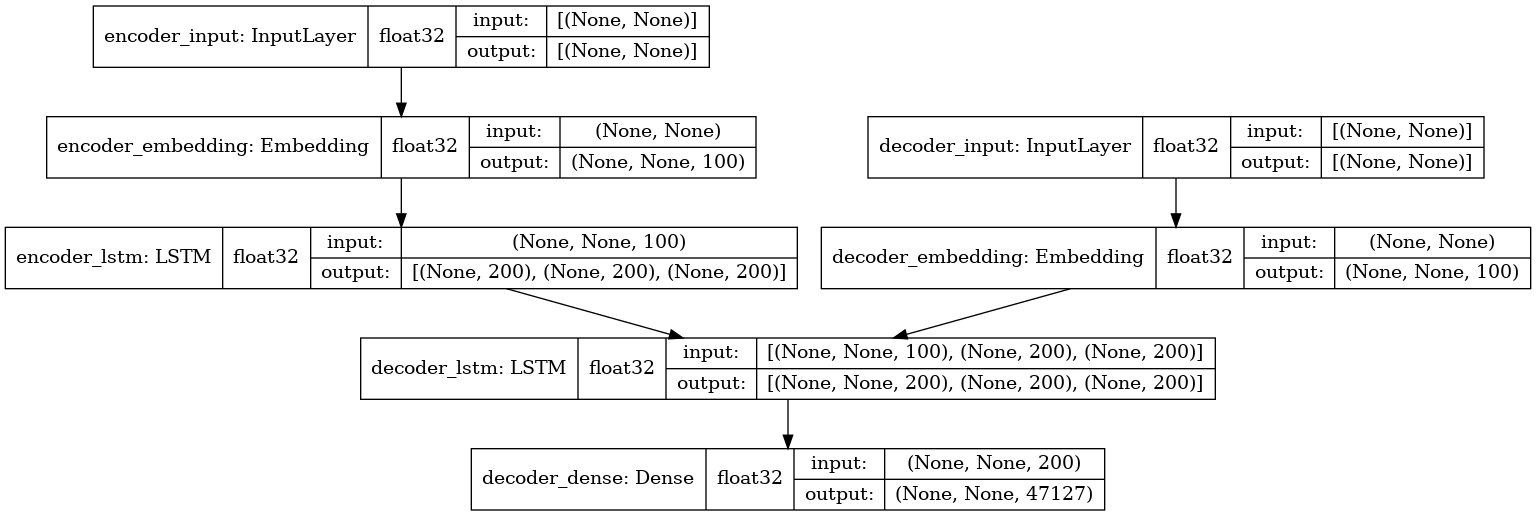

In [416]:
keras.utils.plot_model(transmodel_auto_fr.model,to_file="fr_auto_encoder.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [417]:
transmodel_auto_fr.conf=config_auto_fr
transmodel_auto_fr.cut_model_encoder_decoder()

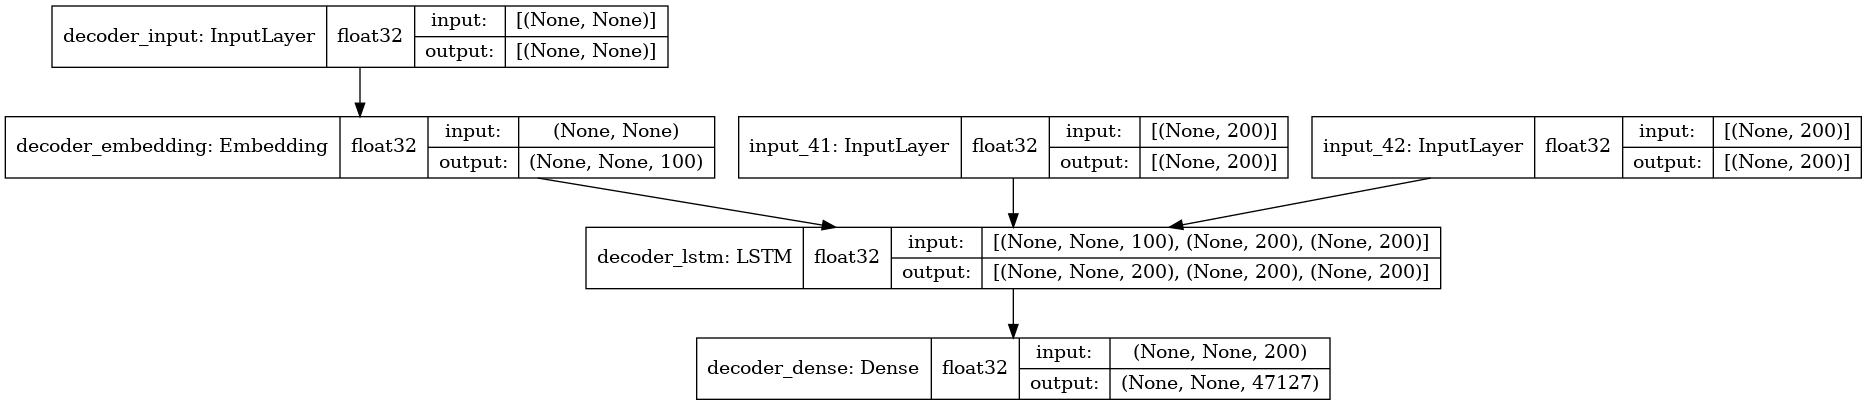

In [418]:
keras.utils.plot_model(transmodel_auto_fr.decoder,to_file="fr_decoder_infer.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

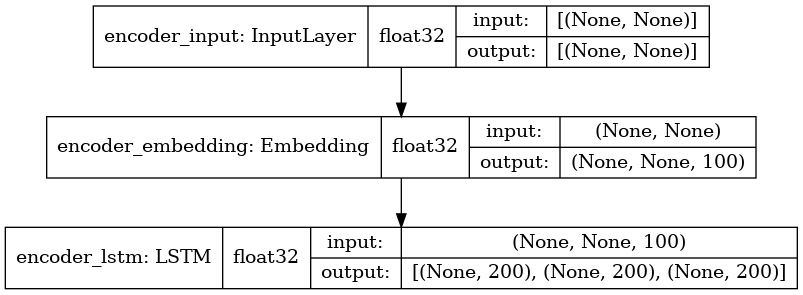

In [419]:
keras.utils.plot_model(transmodel_auto_fr.encoder,to_file="fr_encoder_infer.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

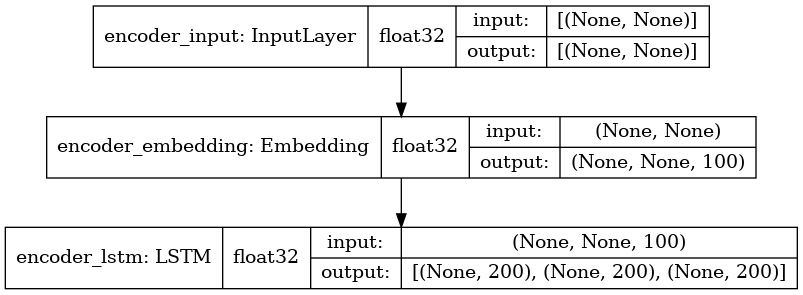

In [420]:
keras.utils.plot_model(transmodel_auto_fr.encoder_hidden,to_file="fr_encoder_hidden.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [421]:
print(config_auto_fr)

Configuration is :

 Vocab size source =47127
 Max length source =50
 Vocab size target =47127
 Max length target= 52
 embedding dim =100
 Nb classe= 3


In [422]:
all_text_auto_encoder=[]
test_sequences_fr=pre_fr_fr.encode_text_for_model(pre_fr_fr.sentences_test,with_vect=False,source=True)
#pre_en_en.tokenizer_target.word_index["<endtoken>"]
#print(states_value.shape)
print(test_sequences_fr[0].shape)

(50,)


In [423]:
trans2=TranslateModel()
trans2.model=transmodel_auto_fr.model
trans2.encoder=transmodel_auto_fr.encoder
trans2.decoder=transmodel_auto_fr.decoder
trans2.encoder_hidden=transmodel_auto_fr.encoder_hidden

In [424]:
trans2.max_length_target=pre_fr_fr.max_length_target
transmodel_auto_fr.max_length_target=pre_fr_fr.max_length_target

In [425]:
print(trans2.max_length_target)

52


# <span id="">Evaluation du bleu score du model auto encodeur</span>

Ici nous allons eevaluer la capacite du modele a faire de la traduction identite<br>
<a href="#top">Back to top</a>


In [426]:

# if ACTION["TRAIN_EN_AUTO_ENCODER"]==True and ACTION["PREDICT_EN_AUTO_ENCODER"]:
#     start_time=time.process_time()
#     alls_auto_encoder_preds=trans2.infer_seq2seq2(test_sequences_en,pre_en_en.tokenizer_target)
#     end_time=time.process_time()

#     first_inference_time=end_time-start_time
#     print("Pour ->",len(test_sequences_en),"l'inference a duree ",first_inference_time,"secondes")
#     print("alls_auto_encoder")

#     print(alls_auto_encoder_preds[50])
#     print(pre_en_en.sentences_test[50])

#     alls_en_auto_trad=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in alls_auto_encoder_preds]
#     print(alls_en_auto_trad[50])

#     #trans2.evaluate_model(pre_en_en.sentences_test,alls_en_auto_trad)
#     all_actuals_predicted=zip(pre_en_en.sentences_test,alls_en_auto_trad)
#     pre_en_en.save_object(all_actuals_predicted,"all_auto_en_traduction.bin")
#     all_text_auto_encoder=alls_en_auto_trad
# else:
#     try:
#         with open("../input/francais-ewondo/en_en_auto_encoder_traductions.txt") as f:
#             data=f.read()
#             data=data.split("\n")
#             all_text_auto_encoder=[]
#             for elt in data:
#                 try:
#                     elt=elt.split("\t")
#                     all_text_auto_encoder.append(elt[1])
#                 except:
#                     pass
#             print(len(all_text_auto_encoder))
#             print(len(pre_en_en.sentences_test))
#     except:
#         pass

# with open("en_en_auto_encoder_traductions.txt","w") as f:
#     list_temp=[]
#     for i,elt in enumerate(all_text_auto_encoder):
#         list_temp.append(pre_en_en.sentences_test[i]+"\t "+elt)
#     f.write("\n".join(list_temp))
#     del list_temp

# transmodel_auto_en.evaluate_model(all_text_auto_encoder,pre_en_en.sentences_test)

# Quelques traductions obtenu par le modele auto encodeur

In [427]:
import random
list_to_display=[]
for elt in range(15):
    list_to_display.append(random.randint(0,len(pre_fr_fr.sentences_test)))
print(list_to_display)

[4170, 2078, 7541, 11172, 10585, 2913, 3307, 1519, 8357, 5572, 8163, 534, 10564, 10213, 9258]


In [428]:
lengths_test=[]
for elt in pre_fr_fr.sentences_test:
    lengths_test.append(len(elt.split()))

print(max(lengths_test))

172


In [429]:
lengthst={}
for elt in lengths_test:
    lengthst[str(elt)]=lengths.get(str(elt),0)+1

In [430]:
print(lengthst)

{'4': 557, '19': 4696, '9': 2739, '16': 4151, '18': 4514, '21': 4796, '43': 2677, '13': 3865, '8': 2312, '11': 3252, '37': 3510, '39': 3271, '24': 4713, '27': 4614, '28': 4621, '49': 1884, '29': 4376, '36': 3582, '57': 8, '30': 4349, '48': 2077, '53': 10, '40': 2957, '67': 2, '73': 1, '41': 2913, '31': 4163, '69': 1, '14': 3918, '32': 4047, '12': 3571, '46': 2259, '98': 1, '20': 4710, '44': 2518, '62': 3, '59': 3, '100': 1, '33': 4002, '42': 2797, '119': 1, '75': 1, '38': 3366, '66': 3, '22': 4693, '10': 2937, '35': 3718, '47': 2189, '45': 2379, '34': 3858, '72': 1, '55': 9, '50': 1811, '7': 1800, '17': 4561, '70': 1, '26': 4655, '88': 1, '52': 10, '78': 1, '25': 4748, '23': 4911, '15': 4125, '60': 4, '51': 10, '6': 1503, '5': 939, '76': 1, '56': 8, '58': 3, '61': 3, '90': 1, '74': 1, '54': 10, '68': 1, '65': 2, '63': 3, '84': 1, '83': 1, '64': 2, '82': 1, '77': 1, '94': 1, '117': 1, '85': 1, '93': 1, '2': 452, '3': 292, '103': 1, '109': 1, '116': 1, '95': 1, '81': 1, '79': 1, '71': 1,

In [431]:
# print("\n\n")
# for i in list_to_display:
#     print("Source: ",pre_en_en.sentences_test[i]+"\n")
#     print("Modele:",all_text_auto_encoder[i])
#     print("\n<---------------->\n")

In [432]:
print(config_auto_fr.max_length_target)

52


In [433]:
fr_encoder=TranslateModel()

#initialisation du modele qui calculera les sorties des phrases anglaises
fr_encoder.model=transmodel_auto_fr.encoder_hidden

In [434]:
#keras.utils.plot_model(en_encoder.model,to_file="en_encoder-hidden-final.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

# [Recupera des poids de l'arhitecture auto encoder de base](http://)

In [435]:
from tensorflow.keras.utils import plot_model
transmodel_auto_fr.tokenizer_source=pre_fr_fr.tokenizer_target

print(len(pre_fr_fr.tokenizer_source.word_index))
#tf.keras.utils.plot_model(
#    transmodel_auto_en2.model, to_file='model1.png', show_shapes=True, show_dtype=True,
#    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
#)
embedding=transmodel_auto_fr.save_embedding_layers()
pre_fr_fr.save_object(embedding,"mini_fr_embedding.pkl")
pre_fr_fr.embedding_target=embedding
pre_fr_fr.embedding=embedding

47126


# Creation des sentences embeddings du francais et de l'anglais

In [436]:
# pre_fr_encoder1=PrepoFrenchEncoder()
# pre_fr_encoder1.load_data(nrows=NROWS,max_length=MAX_LENGTH_SENTENCE)

# sentences_en_train=pre_en_en.encode_text_for_model(pre_en_en.en_aligned,source=True,with_vect=False)
# if ACTION["CREATE_FR_ENCODING"]==True:
#     print("fr encoding creating...")
#     with open("fr_encoding.txt","w") as f:
#         temps=[]
#         dict_fr={}
#         for i in range(0,len(pre_en_en.en_aligned),200):
#             sentences=pre_fr_encoder1.fr_aligned[i:i+200]
#             if ACTION["INTERNAL_REPRESENTATION"]==True:
#                 new_predict=en_encoder.model.predict(sentences_en_train[i:i+200])
#             else:
#                 new_predict= pre_en_en.encode_text_for_model(pre_en_en.en_aligned[i:i+200],source=True,with_vect=True)
            
#             for j,elt in enumerate(sentences):
#                 temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
#                 dict_fr[elt]=new_predict[j]
#         f.write("\n".join(temps))
        
# else:
#     dict_fr=pre_en_en.load_object("../input/francais-ewondo/fr_sentences_encoding.bin")

# pre_en_en.save_object(dict_fr,"fr_sentences_encoding.bin")

In [437]:
if ACTION["CREATE_FR_ENCODING"]==True:
    combine_list=list(set(pre_fr_fr.sentences_source+pre_fr_fr.sentences_test))
    combine_list_fr_train=pre_fr_fr.encode_text_for_model(combine_list,source=True,with_vect=False)
    print("En encoding creating...")
    with open("en_encoding.txt","w") as f:
        temps=[]
        dict_fr={}
        for i in range(0,len(combine_list),200):
            sentences=combine_list[i:i+200]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                new_predict=fr_encoder.model.predict(combine_list_fr_train[i:i+200])
            else:
                new_predict= pre_fr_fr.encode_text_for_model(sentences,source=True,with_vect=True)
            for j,elt in enumerate(sentences):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_fr[elt]=new_predict[j]
        f.write("\n".join(temps))
        pre_fr_fr.save_object(dict_fr,"fr_sentences_encoding.bin")
else:
    dict_fr=pre_fr_fr.load_object("../input/francais-ewondo/fr_sentences_encoding.bin")

In [438]:
print(combine_list_fr_train[800])
print(combine_list_fr_train[0].shape)

[    7    72    13     2   163  3146     3 27566    92   307    14  1171
     3   373  4279    12     7   294     1 12210     1     6     2   163
    32  1692  5352     6     2  2065  1755    13     2    18   469     8
   121  3631     4     0     0     0     0     0     0     0     0     0
     0     0]
(50,)


# <span id="">Decodeur supervise du francais</span>

Ce decodeur est un traducteur classique, il prendra en paramettre des poid de l'anglais <br>
et en sortis donnera des texte en anglais. Sauf que ici les poids de l'anglais sont ceux de la representation universelle<br>
<a href="#top">Back to summary</a>

In [439]:
if ACTION["CREATE_FR_ENCODING"]==True:
    fr_sentences_encoding=pre_fr_fr.load_object("fr_sentences_encoding.bin")
else:
    fr_sentences_encoding=pre_fr_fr.load_object("../input/francais-ewondo/fr_sentences_encoding.bin")

pre_fr_fr.save_object(fr_sentences_encoding,"fr_sentences_encoding.bin")
pre_fr_fr.save_object(fr_sentences_encoding,"fr_sentences_encoding.bin")

In [440]:
keys=list(fr_sentences_encoding.keys())
keys2=list(fr_sentences_encoding.keys())
print(keys[10])
#print(fr_sentences_encoding[keys[0]])
#print(en_sentences_encoding[keys2[0]])

le commissaire a toutefois mentionné un point extrêmement important .


In [441]:
pre_fr_decoder=PrepoTransOther()

#pre_en_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","English","English",100)

pre_fr_decoder.load_tokenizer("./mini_fr_tokenizer.bin")
pre_fr_decoder.max_length_source=DECODER_INPUT_SIZE
pre_fr_decoder.max_length_target=MAX_LENGTH_TARGET+2
pre_fr_decoder.sentences_source=pre_fr_fr.sentences_source
pre_fr_decoder.sentences_target=pre_fr_fr.sentences_target
pre_fr_decoder.sentences_embedding_source=fr_sentences_encoding
pre_fr_decoder.sentences_embedding_target=fr_sentences_encoding
pre_fr_decoder.embedding=embedding
pre_fr_decoder.embedding_target=embedding
pre_fr_decoder.model_source=fr_encoder.model

pairs_fr_decoder=list(zip(pre_fr_fr.sentences_source,pre_fr_fr.sentences_target))



In [442]:
pairs_fr_decoder[0]

("a la fin de la procédure , nous mettrons en garde la commission puis nous lui accorderons la décharge pour l ' exécution du budget , tout cela dans l ' intérêt des contribuables européens , et espérons - le , de nos électeurs .",
 "a la fin de la procédure , nous mettrons en garde la commission puis nous lui accorderons la décharge pour l ' exécution du budget , tout cela dans l ' intérêt des contribuables européens , et espérons - le , de nos électeurs .")

In [443]:
print(len(list(fr_sentences_encoding.keys())))
print(list(fr_sentences_encoding.keys())[0])
print(len(list(set(pairs_fr_decoder))))

if "thank you , commissioner ." in list(fr_sentences_encoding.keys()):
    print("hello")

170952
concernant la chaptalisation , il me semble important de ne pas perdre nos forces sur cette question .
159688


In [444]:
fr_sentences_encoding[keys2[3]].shape

(200,)

In [445]:
#print(fr_sentences_encoding["thank you , commissioner ."].shape)

In [446]:
pairs_fr_test=list(zip(pre_fr_fr.sentences_test,pre_fr_fr.sentences_test))

In [447]:
fr_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    fr_decoder_generator=DecoderGenerator(pairs_fr_decoder,100,pre_fr_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
    fr_val_decoder_generator=DecoderGenerator(pairs_fr_test,100,pre_fr_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
else:
    fr_decoder_generator=TextGenerator(pairs_fr_decoder,100,pre_fr_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
    fr_val_decoder_generator=TextGenerator(pairs_fr_test,100,pre_fr_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])

config_fr_decoder=Config(vocab_size=pre_fr_decoder.vocab_size_source,
              max_length=pre_fr_decoder.max_length_source,
              vocab_size_target=pre_fr_decoder.vocab_size_target,
              max_length_target=pre_fr_decoder.max_length_target,
              embedding_dim=EMBEDDING_SIZE)
    

#en_decoder.init_supervised_decoder(config_en_decoder)
#en_decoder.init_supervised_decoder_with_attention(config_en_decoder)
#en_decoder.init_supervised_decoder_with_attention2(config_en_decoder)
if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("Hello")
    #config_en_decoder.optimizer="sgd"
    DecoderGenerator.model=False
    #en_decoder.init_supervised_decoder(config_en_decoder)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        fr_decoder.init_supervised_decoder_with_auto_en(config_fr_decoder,transmodel_auto_fr.model)
    else:
        print("Inside seq to seq")
        fr_decoder.init_decoder_seq2seq(config_fr_decoder)

    #en_decoder.init_supervised_decoder_with_dense(config_en_decoder)
    #en_decoder.model.optimizer.lr.assign(0.12)
else:
    fr_decoder.init_supervised_decoder_with_attention(config_fr_decoder)
    
fr_decoder.model.summary()
checkpoint_fr_decoder=ModelCheckpoint("fr_decoder_supervised.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
DecoderGenerator.model=False
DecoderGenerator.sentences=True
    #en_decoder.model.optimizer.lr.assign(0.3)
if ACTION["TRAIN_FR_DECODER"]==True:
    print("ok")
    print(fr_decoder.model.optimizer.lr)
    begin_time=time.process_time()
    history_fr_decoder=fr_decoder.model.fit(fr_decoder_generator,validation_data=fr_val_decoder_generator,epochs=NB_DECODER_EPOCHS,initial_epoch=0,callbacks=[checkpoint_fr_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    
    history_fr_decoder.history["duration_training"]=end_time-begin_time
    
    pre_fr_decoder.save_object(history_fr_decoder.history,"fr_decoder_history.bin")
    
    print(history_fr_decoder.history)
    fr_decoder.model.save_weights("fr-decoder-weigths.w")
else:
    fr_decoder.model.load_weights("../input/francais-ewondo/fr-decoder-weigths.w")
    fr_decoder.model.save_weights("fr-decoder-weigths.w")
    #history_fr_decoder=pre_fr_decoder.load_object("../input/francais-ewondo/fr_decoder_history.bin")
    #pre_fr_decoder.save_object(history_fr_decoder,"fr_decoder_history.bin")
    #print(history_fr_decoder)

fr_decoder.model.summary()


Inside generator source maxlength=  50
Inside generator target maxlength= 52
Inside generator source maxlength=  50
Inside generator target maxlength= 52
Hello
Inside seq to seq
Model: "model_80"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, None, 200)]  0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 100)    4712700     decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_lstm

In [448]:
#history_fr_decoder=fr_decoder.model.fit(fr_decoder_generator,validation_data=fr_val_decoder_generator,epochs=NB_DECODER_EPOCHS,initial_epoch=24,callbacks=[checkpoint_fr_decoder],verbose=VERBOSE)


In [449]:
#fr_decoder.model.save_weights("fr-decoder-weigths.w")

In [450]:
print(DecoderGenerator.embedding_size)

100


In [451]:
test_shape=fr_decoder_generator.__getitem__(0)

In [452]:
#keras.utils.plot_model(en_decoder.model,to_file="en_decoder_supervised.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [453]:
print(fr_decoder_generator.__getitem__(0)[1][0].shape)
print(DECODER_INPUT_SIZE)
print(config_fr_decoder)
print(pre_fr_decoder.max_length_source)
print(pre_fr_decoder.max_length_target)
print(fr_decoder_generator.__getitem__(0)[0][0].shape)

(52,)
50
Configuration is :

 Vocab size source =47127
 Max length source =50
 Vocab size target =47127
 Max length target= 52
 embedding dim =100
 Nb classe= 3
50
52
(100, 1, 200)


# Evaluation du decoder supervise du francais

In [454]:
fr_decoder.conf=config_fr_decoder
fr_decoder.cut_model_encoder_decoder()
fr_decoder.max_length_target=pre_fr_fr.max_length_target

print("Avaluation du decoder supervise de l'anglais\n")
pre_fr_decoder.sentences_test=pre_fr_fr.sentences_test
pre_fr_decoder.sentences_test=pre_fr_fr.sentences_test
all_fr_text_decoder=[]

#all_fr_text_decoder=evaluate_decoder_traduction(fr_encoder,fr_decoder,pre_fr_decoder,"fr",ACTION["EVALUATE_FR_DECODER"])
print(len(pre_fr_decoder.sentences_test))

Avaluation du decoder supervise de l'anglais

11369


In [455]:
all_fr_text_decoder2=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_fr_text_decoder]
# print(all_fr_text_decoder2[0])
# print(all_fr_text_decoder[0])

#fr_decoder.evaluate_model(pre_fr_decoder.sentences_test,all_fr_text_decoder2)

In [456]:
# print("Quelques phrases du decodeur supervise de l'anglais")
# for i in list_to_display:
#     print("Source: ",pre_fr_fr.sentences_test[i]+"\n")
#     print("Modele:",all_fr_text_decoder[i])
#     print("\n<---------------->\n")

# Construction des concernants de l'ewondo

In [457]:
pre_ewondo=PrepoEwondo()
pre_ewondo.load_data()
pre_ewondo.create_tokenizer_source("\n")
pre_ewondo.max_length_source+=2
pre_ewondo.tokenizer_target=pre_fr_fr.tokenizer_source
pre_ewondo.max_length_target=pre_fr_fr.max_length_source
pre_ewondo.vocab_size_target=pre_fr_fr.vocab_size_source


print(pre_ewondo.sentences_target[0])
all_ewondo_target=list(pre_ewondo.sentences_target)+list(pre_ewondo.french_test)
sentences_fr_ewondo_train=pre_fr_fr.encode_text_for_model(all_ewondo_target,source=True,with_vect=False)
print(sentences_fr_ewondo_train[0])
_shape=sentences_fr_ewondo_train.shape
new_shape_fr_ewondo=np.reshape(sentences_fr_ewondo_train,(_shape[0],_shape[1],1))


if ACTION["CREATE_EWONDO_ENCODING"]==True:
    all_ewondo_texts=list(pre_ewondo.sentences_source)+list(pre_ewondo.sentences_test)
    
    print("ewondo  encoding creating...")
    with open("ewondo_encoding.txt","w") as f:
        temps=[]
        dict_ewondo={}
        for i in range(0,len(all_ewondo_target),200):
            sentences=all_ewondo_texts[i:i+200]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                new_predict=fr_encoder.model.predict(new_shape_fr_ewondo[i:i+200])
            else:
                new_predict= pre_fr_fr.encode_text_for_model(all_ewondo_target[i:i+200],source=True,with_vect=True)
            
            for j,elt in enumerate(sentences):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_ewondo[elt]=new_predict[j]
        f.write("\n".join(temps))
        pre_ewondo.save_object(dict_ewondo,"ewondo_sentences_encoding.bin")
        ewondo_sentences_encoding=dict_ewondo
else:
    ewondo_sentences_encoding=pre_fr_fr.load_object("../input/francais-ewondo/ewondo_sentences_encoding.bin")
    pre_ewondo.save_object(ewondo_sentences_encoding,"ewondo_sentences_encoding.bin")

pre_ewondo.sentences_embedding_target=ewondo_sentences_encoding
if ACTION["TRAIN_EWONDO_ENCODER"]==True:
    pre_ewondo.create_tokenizer_source("\n")
    pre_ewondo.max_length_source+=2
    print("hello i am in encoder of ewondo")
    #pre_fr_encoder.max_length_source=MAX_LENGTH_SOURCE
else:
    pre_ewondo.load_tokenizer("../input/francais-ewondo/ewondo_mini_tokenizer.bin")

#pre_ewondo.embedding_target=pre_yemba.load_object("./mini_en_embedding.pkl")

pre_ewondo.tokenizer_target=pre_fr_fr.tokenizer_source
pre_ewondo.max_length_target=ENCODER_OUTPUT_SIZE
pre_ewondo.vocab_size_target=pre_fr_fr.vocab_size_target
pre_ewondo.save_tokenizer("ewondo_mini_tokenizer.bin")
print(pre_ewondo.sentences_test[0])
print(pre_ewondo.sentences_source[0])

print(sentences_fr_ewondo_train[1000])


#Ici etant donne que nous devons utiliser la representation contexte anglais, nous nous devons
#donc d'avoir l'equivalent des phrases francaises en anglais
#Raison pour laquelle sentences source et sentences target sont equivalent
sentences_pairs_encoder_ewondo=list(zip(pre_ewondo.sentences_source,pre_ewondo.sentences_source))
sentences_pairs_ewondo_test=list(zip(pre_ewondo.sentences_test,pre_ewondo.sentences_test))


ewondo_encoder=TranslateModel()
#auto_en=keras.models.load_model("./en_auto_encoder_attention.h5")
#en_encoder.init_hidden_state_model(config_auto_en,auto_en)
pre_ewondo.model_target=fr_encoder.model


#maintenant que nous avons fait le premier pretraitement, nous devons maintenant
config_ewondo_enc=Config(vocab_size=pre_ewondo.vocab_size_source,
              max_length=pre_ewondo.max_length_source,
              vocab_size_target=pre_ewondo.vocab_size_target,
              max_length_target=pre_ewondo.max_length_target,
              embedding_dim=EMBEDDING_SIZE)

print("Configuration de la langue ewondo")
print(config_ewondo_enc)

ewondo_encoder=TranslateModel()
if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("Hello i try ewondo")
    ewondo_encoder.init_supervised_encoder(config_ewondo_enc)
else:
    ewondo_encoder.init_supervised_encoder2(config_ewondo_enc)
EncoderGenerator.model=False
EncoderGenerator.sentences=True
#fr_encoder.init_supervised_encoder_with_dense(config_fr_enc)
ewondo_encoder.model.summary()

modelcheckpoint_ewondo_encodeur=ModelCheckpoint("mini_ewondo_encodeur.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
checkpoint_ewondo_encoder_mse=ModelCheckpoint("mini_ewondo_encoder_mse.h5",save_best_only=True,verbose=1,monitor="mse",mode="min")
checkpoint_ewondo_encoder_cos=ModelCheckpoint("mini_ewondo_encoder_cos.h5",save_best_only=True,verbose=1,monitor="cosine_similarity",mode="max")

ewondo_encoder_generator=EncoderGenerator(sentences_pairs_encoder_ewondo,100,pre_ewondo,shuffle=True,with_vect=False,prediction=False)
ewondo_encoder_val_generator=EncoderGenerator(sentences_pairs_ewondo_test,100,pre_ewondo,shuffle=True,with_vect=False,prediction=False)


if ACTION["TRAIN_EWONDO_ENCODER"]==True:
    print("Entrainement de l'encodeur supervise de l'ewondo")
    begin_time=time.process_time()
    history_ewondo_encoder=ewondo_encoder.model.fit(ewondo_encoder_generator,validation_data=ewondo_encoder_val_generator,epochs=NB_ENCODER_EPOCHS*2,initial_epoch=0,callbacks=[modelcheckpoint_ewondo_encodeur,checkpoint_ewondo_encoder_mse,checkpoint_ewondo_encoder_cos],verbose=VERBOSE)
    end_time=time.process_time()
    history_ewondo_encoder.history["duration_training"]=end_time-begin_time
    pre_ewondo.save_object(history_ewondo_encoder.history,"ewondo_encoder_train_history.obj")
    history_ewondo_encoder=history_ewondo_encoder.history
    
else:
    model_ewondo=keras.models.load_model("../input/francais-ewondo/mini_ewondo_encodeur.h5")
    model_ewondo.save("mini_ewondo_encodeur.h5")

    model_ewondo=keras.models.load_model("../input/francais-ewondo/mini_ewondo_encoder_cos.h5")
    model_ewondo.save("mini_ewondo_encoder_cos.h5")

    model_ewondo=keras.models.load_model("../input/francais-ewondo/mini_ewondo_encoder_mse.h5")
    model_ewondo.save("mini_ewondo_encoder_mse.h5")
    
    history_ewondo_encoder=pre_ewondo.load_object("../input/francais-ewondo/ewondo_encoder_train_history.obj")
    pre_ewondo.save_object(history_ewondo_encoder,"yemba_encoder_train_history.obj")

    ewondo_encoder.model=model_ewondo
    
print("Historique d'entraiment de l'encodeur supervisé de l'ewondo ")
print(history_ewondo_encoder)


print("Evaluation de l'encodeur ewondo")
evaluate_encoder(ewondo_encoder,pre_ewondo.sentences_test,pre_ewondo,fr_encoder, pre_ewondo.french_test,pre_fr_decoder,reshape=True)



Source max_length is  63
après le sabbat , dès l ' aube du premier jour de la semaine , marie - madeleine et l ' autre marie allèrent visiter le sépulcre .
[  188     7  6989     3   281     6     2 10516    20   296   231     1
     5   728     3  5630    21 25451     8     6     2   153  5630 11955
  8598     7 20603     4     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
ewondo  encoding creating...
ndò angasò a bëyègè bëngabë , asò bò koe bëkëlë oyò , nyè ai petrus na : dze yë miabëbëlë ki e ngul ya atòbò evie ai ma nguma awola mbòg ?
a mvus sabbat , kikidigi ai ndib , a amos osu , ndò maria magdalena ai e maria mbòg bëngakë na bakë yen sòṅ .
[ 2779  3366     5   637    76    80  2463     3   154    21    24     3
    63    45     2    16    46     3 30220    12    53     2  6308    10
    46    31     9  1512     4    80     0     0     0     0     0     0
     0     0     0     0     0     0     

{'mse': 0.036888547, 'cos': 0.8125814447800318}

In [458]:
f_ew=ewondo_encoder_generator.__getitem__(0)

In [459]:
pre_ewondo_decoder=PrepoTransOther()
#pre_es_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","French","French",nrows=100)
pre_ewondo_decoder.sentences_source=pre_ewondo.sentences_source
pre_ewondo_decoder.sentences_target=pre_ewondo.sentences_source
pre_ewondo_decoder.sentences_test=pre_ewondo.sentences_test

pre_ewondo_decoder.sentences_embedding_source=ewondo_sentences_encoding



pre_ewondo_decoder.load_tokenizer("./ewondo_mini_tokenizer.bin")
pre_ewondo_decoder.tokenizer_source=pre_ewondo.tokenizer_source
pre_ewondo_decoder.max_length_source= pre_ewondo.max_length_source #DECODER_INPUT_SIZE #pre_ewondo.max_length_source
pre_ewondo_decoder.vocab_size_source=pre_ewondo.vocab_size_source
pre_ewondo_decoder.vocab_size_target=pre_ewondo.vocab_size_target
pre_ewondo_decoder.tokenizer_target=pre_ewondo.tokenizer_source
pre_ewondo_decoder.max_length_target=pre_ewondo.max_length_source
#pre_es_decoder.model_source=es_encoder.model
#pre_ewondo_decoder.max_length_source=DECODER_INPUT_SIZE

pairs_ewondo_decoder=list(zip(pre_ewondo_decoder.sentences_source,pre_ewondo_decoder.sentences_source))
pairs_ewondo_test=list(zip(pre_ewondo.sentences_test,pre_ewondo.sentences_test))

#Maintenant que nous avons load les donnees, nous devons maintenant creer 
#le generateur de l'anglais en francais

ewondo_decoder_generator=DecoderGenerator(pairs_ewondo_decoder,100,pre_ewondo_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
ewondo_decoder_val_generator=DecoderGenerator(pairs_ewondo_test,100,pre_ewondo_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
DecoderGenerator.sentences=True
DecoderGenerator.model=False


config_ewondo_dec=Config(vocab_size=pre_ewondo_decoder.vocab_size_source,
              max_length=pre_ewondo_decoder.max_length_source,
              vocab_size_target=pre_ewondo_decoder.vocab_size_source,
              max_length_target=pre_ewondo_decoder.max_length_target,
              embedding_dim=EMBEDDING_SIZE)

ewondo_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("hello internal")
     #en_decoder.init_supervised_decoder(config_en_decoder)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        ewondo_decoder.init_supervised_decoder_with_attention2(config_ewondo_dec) 
    else:
        print("Inside seq to seq")
        ewondo_decoder.init_decoder_seq2seq(config_ewondo_dec)
    #es_decoder.init_supervised_decoder_with_dense(config_es_dec)
else:
    ewondo_decoder.init_supervised_decoder_with_attention(config_ewondo_dec)
#es_decoder.init_supervised_decoder_with_auto_en(config_es_dec,transmodel_auto_en.model)

ewondo_decoder.model.summary()
checkpoint_ewondo_decoder=ModelCheckpoint("ewondo_decoder.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")

if ACTION["TRAIN_EWONDO_DECODER"]==True:
    
    begin_time=time.process_time()
    history_ewondo_decoder=ewondo_decoder.model.fit(ewondo_decoder_generator,validation_data=ewondo_decoder_val_generator,epochs=NB_DECODER_EPOCHS*2,initial_epoch=0,callbacks=[checkpoint_ewondo_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    
    history_ewondo_decoder.history["duration_training"]=end_time-begin_time
    
    pre_ewondo_decoder.save_object(history_ewondo_decoder.history,"ewondo_decoder_train_history.obj")
    history_ewondo_decoder=history_ewondo_decoder.history
    #separatin du modele yemba en encodeu et decodeur pour la phase d'inference
    ewondo_decoder.model.save_weights("ewondo-decoder-weigths.w")

else:
    ewondo_decoder.model.load_weights("../input/francais-ewondo/ewondo-decoder-weigths.w")
    ewondo_decoder.model.save_weights("ewondo-decoder-weigths.w")
    history_ewondo_decoder=pre_ewondo_decoder.load_object("../input/francais-ewondo/ewondo_decoder_train_history.obj")
    pre_ewondo_decoder.save_object(history_ewondo_decoder,"ewondo_decoder_train_history.obj")
    
print("Historique d'enrainement du decodeur yemba")
print(history_ewondo_decoder)
ewondo_decoder.conf=config_ewondo_dec
ewondo_decoder.cut_model_encoder_decoder()


print("Metric bleu score, pour le decoder ewondo")
ewondo_decoder.max_length_target=pre_ewondo.max_length_source
print(ewondo_decoder.max_length_target)
#all_ewondo_decoder_sentences=evaluate_decoder_traduction(ewondo_encoder,ewondo_decoder,pre_ewondo_decoder,'ewondo',ACTION["EVALUATE_EWONDO_DECODER"])


Inside generator source maxlength=  65
Inside generator target maxlength= 65
Inside generator source maxlength=  65
Inside generator target maxlength= 65
hello internal
Inside seq to seq
Model: "model_84"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, None, 200)]  0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 100)    403700      decoder_input[0][0]              
__________________________________________________________________________________________________
enc

# Evaluation de la traduction Francais Ewondo-et Vice Versa

In [460]:
ewondo_test=pre_ewondo.sentences_test

#all_en_to_ewondo_texts=evaluate_two_traduction(en_encoder,pre_en_en,pre_ewondo.english_test,ewondo_decoder,pre_ewondo_decoder,pre_ewondo.sentences_test,"en","ewondo",ACTION["EVALUATE_EN_EWONDO"])

all_fr_to_ewondo_texts=evaluate_two_traduction(fr_encoder,pre_fr_fr,pre_ewondo.french_test,ewondo_decoder,pre_ewondo_decoder,pre_ewondo.sentences_test,"fr","ewondo",ACTION["EVALUATE_FR_EWONDO"])

#all_spanish_to_ewondo_texts=evaluate_two_traduction(es_encoder,pre_es_encoder,pre_ewondo.spanish_test,ewondo_decoder,pre_ewondo_decoder,ewondo_test,"es","ewondo",ACTION["EVALUATE_SPANISH_EWONDO"])

all_ewondo_to_fr_texts=evaluate_two_traduction(ewondo_encoder,pre_ewondo,ewondo_test,fr_decoder,pre_fr_decoder,pre_ewondo.french_test,"ewondo","fr",ACTION["EVALUATE_EWONDO_FR"])

#all_ewondo_to_spanish_texts=evaluate_two_traduction(ewondo_encoder,pre_ewondo,ewondo_test,es_decoder,pre_es_decoder,pre_ewondo.spanish_test,"ewondo","es",ACTION["EVALUATE_EWONDO_SPANISH"])

#all_ewondo_to_en_texts=evaluate_two_traduction(ewondo_encoder,pre_ewondo,ewondo_test,en_decoder,pre_en_decoder,pre_ewondo.english_test,"ewondo","en",ACTION["EVALUATE_EWONDO_EN"])

In [461]:
print("Evauation de la traduction francais -> Ewondo")
ewondo_decoder.evaluate_model(pre_ewondo.sentences_test,all_fr_to_ewondo_texts)
print("<----------------->\n")

print("Evauation de la traduction Ewondo -> Francais ")
ewondo_decoder.evaluate_model(pre_ewondo.french_test,all_ewondo_to_fr_texts)
print("<----------------->\n")


Evauation de la traduction francais -> Ewondo
BLEU-1: 0.188554
BLEU-2: 0.088336
BLEU-3: 0.063656
BLEU-4: 0.026617
<----------------->

Evauation de la traduction Ewondo -> Francais 
BLEU-1: 0.226449
BLEU-2: 0.079556
BLEU-3: 0.043642
BLEU-4: 0.015295
<----------------->



# Traduction bilingue Francais-Ewondo

In [462]:
pre_fr_ewondo=PrepoTransEn()
with open("../input/ewondodatasets/ewondo-fr.txt") as f:
    data=f.read().split("\n")
    for elt in data:
        elt2=elt.split("\t")
        pre_fr_ewondo.sentences_source.append(elt2[1])
        pre_fr_ewondo.sentences_target.append(elt2[0])
with open("../input/ewondodatasets/ewondo-fr-test.txt") as f:
    data=f.read().split("\n")
    for elt in data:
        elt2=elt.split("\t")
        pre_fr_ewondo.sentences_test.append(elt2[1])
        pre_fr_ewondo.sentences_test_target.append(elt2[0])

In [463]:
pre_fr_ewondo.create_tokenizer_source("\n")
pre_fr_ewondo.create_tokenizer_target("\n")

Source max_length is  80
Target max_length is  63


In [464]:
print(len(pre_fr_ewondo.sentences_test))

300


In [465]:
sentences_fr_ew_train=list(zip(pre_fr_ewondo.sentences_source,pre_fr_ewondo.sentences_target))

sentences_fr_ew_val=list(zip(pre_fr_ewondo.sentences_test,pre_fr_ewondo.sentences_test_target))
print(sentences_fr_ew_train[0])

("après le sabbat , dès l ' aube du premier jour de la semaine , marie - madeleine et l ' autre marie allèrent visiter le sépulcre .", 'a mvus sabbat , kikidigi ai ndib , a amos osu , ndò maria magdalena ai e maria mbòg bëngakë na bakë yen sòṅ .')


In [466]:
conf_fr_ewondo=Config(vocab_size=pre_fr_ewondo.vocab_size_source,
              max_length=pre_fr_ewondo.max_length_source,
              vocab_size_target=pre_fr_ewondo.vocab_size_target,
              max_length_target=pre_fr_ewondo.max_length_target,
              embedding_dim=EMBEDDING_SIZE)

train_generator_fr_ew=TextGenerator(sentences_fr_ew_train,100,pre_fr_ewondo,shuffle=True,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
val_generator_fr_ew=TextGenerator(sentences_fr_ew_val,100,pre_fr_ewondo,shuffle=False,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])

transmodel_fr_ew=TranslateModel()

transmodel_fr_ew.init_autoencoder_seq2seq(conf_fr_ewondo)
    
transmodel_fr_ew.model.summary()

modelcheckpoint_fr_ew=ModelCheckpoint("fr_to_ewondo.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")#

begin_time=time.process_time()
history_fr_ew=transmodel_fr_ew.model.fit(train_generator_fr_ew,epochs=35,initial_epoch=0, validation_data=val_generator_fr_ew,callbacks=[modelcheckpoint_fr_ew],verbose=VERBOSE)
end_time=time.process_time()
history_fr_ew.history["duration_training"]=end_time-begin_time
print("Le modele a pris ",end_time-begin_time, "pour s'entrainer ")
pre_fr_fr.save_object(history_fr_ew.history,"fr_ew_history.obj")
print(history_fr_ew.history)
transmodel_fr_ew.model.save_weights("fr_to_ewondo.w")




Inside generator source maxlength=  80
Inside generator target maxlength= 63
Inside generator source maxlength=  80
Inside generator target maxlength= 63
Model: "model_88"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 100)    450400      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (Non

In [467]:
transmodel_fr_ew.conf=conf_fr_ewondo
transmodel_fr_ew.cut_model_encoder_decoder()
transmodel_fr_ew.max_length_target=pre_fr_ewondo.max_length_target

In [468]:
test_sequences_fr=pre_fr_ewondo.encode_text_for_model(pre_fr_ewondo.sentences_test,with_vect=False,source=True)
    
all_fr_to_ewondo_bil=transmodel_fr_ew.infer_seq2seq2(test_sequences_fr,pre_fr_ewondo.tokenizer_target)


alls_fr_ew_auto_trad=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_fr_to_ewondo_bil]
print(alls_fr_ew_auto_trad[50])

all_actuals_predicted=zip(pre_fr_ewondo.sentences_test,alls_fr_ew_auto_trad)
pre_fr_ewondo.save_object(all_actuals_predicted,"all_fr_to_ew_bil_traduction.bin")
all_text_fr_ew_bil=alls_fr_ew_auto_trad


with open("fr_ew_bil_traductions.txt","w") as f:
    list_temp=[]
    for i,elt in enumerate(all_text_fr_ew_bil):
        list_temp.append(pre_fr_ewondo.sentences_test[i]+"\t "+elt)
    f.write("\n".join(list_temp))
    del list_temp



ndò hm na : a nti ,


In [469]:
print("Evaluation de la traduction bilingue Francais Ewondo")
transmodel_fr_ew.evaluate_model(all_text_fr_ew_bil,pre_fr_ewondo.sentences_test_target)

Evaluation de la traduction bilingue Francais Ewondo
BLEU-1: 0.270548
BLEU-2: 0.120702
BLEU-3: 0.080566
BLEU-4: 0.032694


In [477]:
print(all_text_fr_ew_bil[190])
print(pre_fr_ewondo.sentences_test_target[1])

ndò hm e mod , ndò hm na : a nti , ndò fë e nyò a yob ,
kogëlan , mitòbò evie , asu yë na të miaku a mëbobëla . amu nsisim onë nkanga , nyòl etoa ntëgan .


# Traduction Bilingue Francais-Ewondo

In [471]:
pre_ew_fr=PrepoTransEn()
pre_ew_fr.tokenizer_source=pre_fr_ewondo.tokenizer_target
pre_ew_fr.tokenizer_target=pre_fr_ewondo.tokenizer_source

pre_ew_fr.vocab_size_source=pre_fr_ewondo.vocab_size_target
pre_ew_fr.max_length_source=pre_fr_ewondo.max_length_target
pre_ew_fr.sentences_source=pre_fr_ewondo.sentences_target
pre_ew_fr.sentences_test=pre_fr_ewondo.sentences_test_target

pre_ew_fr.sentences_test_target=pre_fr_ewondo.sentences_test
pre_ew_fr.sentences_target=pre_fr_ewondo.sentences_source
pre_ew_fr.vocab_size_target=pre_fr_ewondo.vocab_size_source
pre_ew_fr.max_length_target=pre_fr_ewondo.max_length_source


In [472]:
sentences_ew_fr_train=list(zip(pre_ew_fr.sentences_source,pre_ew_fr.sentences_target))
sentences_ew_fr_val=list(zip(pre_ew_fr.sentences_test,pre_ew_fr.sentences_test_target))
conf_ew_fr=Config(vocab_size=pre_ew_fr.vocab_size_source,
              max_length=pre_ew_fr.max_length_source,
              vocab_size_target=pre_ew_fr.vocab_size_target,
              max_length_target=pre_ew_fr.max_length_target,
              embedding_dim=EMBEDDING_SIZE)

train_generator_ew_fr=TextGenerator(sentences_ew_fr_train,100,pre_ew_fr,shuffle=True,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
val_generator_ew_fr=TextGenerator(sentences_ew_fr_val,100,pre_ew_fr,shuffle=False,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])

transmodel_ew_fr=TranslateModel()

transmodel_ew_fr.init_autoencoder_seq2seq(conf_ew_fr)
    
transmodel_ew_fr.model.summary()

modelcheckpoint_ew_fr=ModelCheckpoint("fr_to_ewondo.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")#

begin_time=time.process_time()
history_ew_fr=transmodel_ew_fr.model.fit(train_generator_ew_fr,epochs=35,initial_epoch=0, validation_data=val_generator_ew_fr,callbacks=[modelcheckpoint_ew_fr],verbose=VERBOSE)
end_time=time.process_time()
history_ew_fr.history["duration_training"]=end_time-begin_time
print("Le modele a pris ",end_time-begin_time, "pour s'entrainer ")
pre_ew_fr.save_object(history_ew_fr.history,"ew_fr_history.obj")
print(history_ew_fr.history)
transmodel_ew_fr.model.save_weights("ewondo_to_fr.w")



Inside generator source maxlength=  63
Inside generator target maxlength= 80
Inside generator source maxlength=  63
Inside generator target maxlength= 80
Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 100)    403700      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (Non

In [473]:
transmodel_ew_fr.conf=conf_ew_fr
transmodel_ew_fr.max_length_target=pre_ew_fr.max_length_target
transmodel_ew_fr.cut_model_encoder_decoder()

In [474]:
test_sequences_fr=pre_ew_fr.encode_text_for_model(pre_ew_fr.sentences_test,with_vect=False,source=True)
    
all_ew_fr_bil=transmodel_fr_ew.infer_seq2seq2(test_sequences_fr,pre_ew_fr.tokenizer_target)


alls_ew_to_fr_trad=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_ew_fr_bil]
print(alls_fr_ew_auto_trad[50])

all_actuals_predicted=zip(pre_ew_fr.sentences_test,alls_ew_to_fr_trad)
pre_fr_ewondo.save_object(all_actuals_predicted,"all_fr_to_ew_bil_traduction.bin")
all_text_ew_fr_bil=alls_ew_to_fr_trad


with open("ew_fr_bil_traductions.txt","w") as f:
    list_temp=[]
    for i,elt in enumerate(all_text_ew_fr_bil):
        list_temp.append(pre_ew_fr.sentences_test[i]+"\t "+elt)
    f.write("\n".join(list_temp))
    del list_temp



ndò hm na : a nti ,


In [475]:
print("Evaluation de la traduction Ewondo-Francais en bilingue")
transmodel_fr_ew.evaluate_model(all_text_ew_fr_bil,pre_ew_fr.sentences_test_target)

Evaluation de la traduction Ewondo-Francais en bilingue
BLEU-1: 0.056450


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-2: 0.008712
BLEU-3: 0.032468
BLEU-4: 0.045113
